In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

In [2]:
import dezero
from dezero import cuda
from typing import List, Optional, Tuple, Any
import math
import dezero.functions as F
import dezero.layers as L

class CustomLSTM(L.Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()

        H, I = hidden_size, in_size
        self.x2f = L.Linear(H, in_size=I)
        self.x2i = L.Linear(H, in_size=I)
        self.x2o = L.Linear(H, in_size=I)
        self.x2u = L.Linear(H, in_size=I)
        self.h2f = L.Linear(H, in_size=H, nobias=True)
        self.h2i = L.Linear(H, in_size=H, nobias=True)
        self.h2o = L.Linear(H, in_size=H, nobias=True)
        self.h2u = L.Linear(H, in_size=H, nobias=True)
        self.reset_state()

    def reset_state(self):
        self.h = None
        self.c = None

    def forward(self, x, h=None, c=None):
        if not (h is None) and not (c is None):
            self.h, self.c = h, c
        if self.h is None:
            f = F.sigmoid(self.x2f(x))
            i = F.sigmoid(self.x2i(x))
            o = F.sigmoid(self.x2o(x))
            u = F.tanh(self.x2u(x))
        else:
            f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
            i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
            o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
            u = F.tanh(self.x2u(x) + self.h2u(self.h))

        if self.c is None:
            c_new = i * u
        else:
            c_new = (f * self.c) + (i * u)

        h_new = o * F.tanh(c_new)
        
        hidden = h_new[: , -1, :] # this is the last hidden state (we are only interested in the last hidden state for the classification task)
        print(hidden.shape)

        self.h, self.c = h_new, c_new
        return h_new, c_new


In [3]:
cuda.cupy

<module 'cupy' from '/usr/local/lib/python3.10/dist-packages/cupy/__init__.py'>

In [4]:
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/time_layers.py
class TimeLSTM(L.Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.in_size = in_size
        
        self.h = None
        self.c = None
    
    def set_state(self, h, c):
        self.h, self.c = h, c
    
    def reset_state(self):
        self.h, self.c = None, None
    
    def forward(self, xs):
        # xs is a batch of sequences
        # xs is a 3D array with shape (batch_size, sequence_length, input_size)
        xp = cuda.get_array_module(xs)
        
        # hs is the hidden states of the LSTM
        hs = xp.empty(N, T, self.hidden_size, dtype=np.float32)
        
        N, T, D = xs.shape # T means time
        # N is the batch size, T is the sequence length, D is the input size
            
        for t in range(T):
            # in_size will be 5, which is the size of the input
            # hidden_size will be 100, which is the size of the hidden state
            lstm = L.LSTM(self.in_size, self.hidden_size)
            self.h, self.c = lstm(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
        
        return hs, (self.h, self.c) # hs is the hidden states of the LSTM
        # self.h is the last hidden state of the LSTM
        # self.c is the last cell state of the LSTM
        
        

In [5]:
import numpy as np

test_data = np.random.randn(4, 101, 5)
test_lstm = CustomLSTM(128, 5)
test_lstm(test_data)

(4, 128)


(variable([[[-0.11737293  0.01211449 -0.20305337 ...  0.19138867 -0.06379931
             -0.29736945]
            [-0.26681177 -0.0063825  -0.15122159 ...  0.02726873  0.10088797
             -0.00216319]
            [ 0.05277946 -0.14184331  0.03286313 ... -0.53789264  0.00193029
              0.45376375]
            ...
            [-0.16750853  0.02065082 -0.03949837 ...  0.04110751  0.12244925
              0.2315478 ]
            [ 0.15770416  0.03604209  0.09149084 ... -0.17362231 -0.07330189
             -0.02637837]
            [-0.22684241  0.02774631  0.01005369 ...  0.14362561 -0.12403968
             -0.15387189]]
          
           [[-0.21842695 -0.0188852  -0.12538004 ...  0.13742125  0.0099677
              0.02112648]
            [-0.1096017  -0.08590477  0.02395355 ... -0.1553159   0.14418655
              0.11163953]
            [ 0.17575373 -0.12543589  0.09989567 ... -0.20697917  0.0285766
              0.00671371]
            ...
            [-0.02758719 -0.106

In [6]:
dataset_dir = "../data/sketchrnn/"
dataset_name = "sketchrnn_apple.npz"
dict_data = np.load(dataset_dir + dataset_name, encoding='latin1', allow_pickle=True)
# extract the first array

print(dict_data)

NpzFile '../data/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid


In [7]:
import utils

train = dict_data['train']
print(train.shape) # we have 70000 sketches
# each seq length varies!

(70000,)


In [8]:
print(train[0].shape, train[1].shape, train[2].shape) # each sketch has a different length

(43, 3) (26, 3) (33, 3)


In [9]:
train[0][1]

array([-19, -14,   0], dtype=int16)

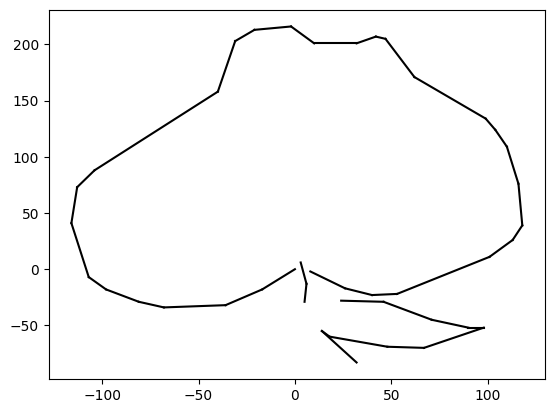

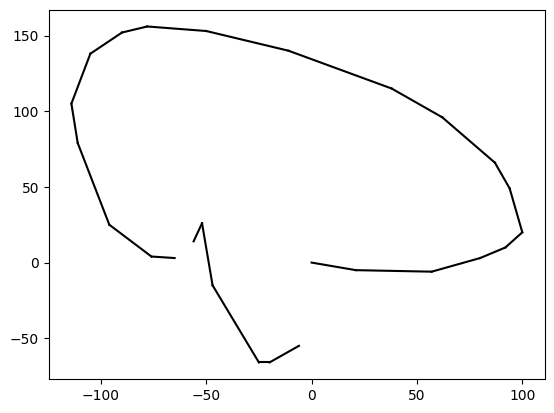

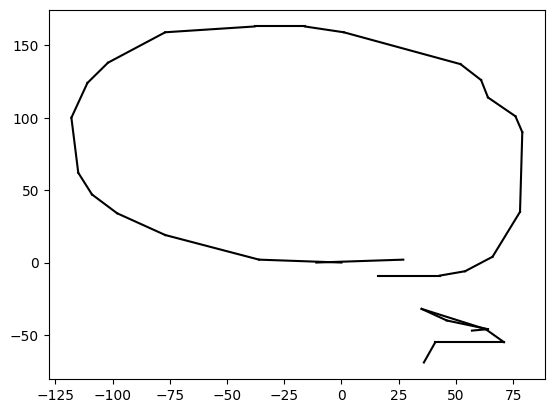

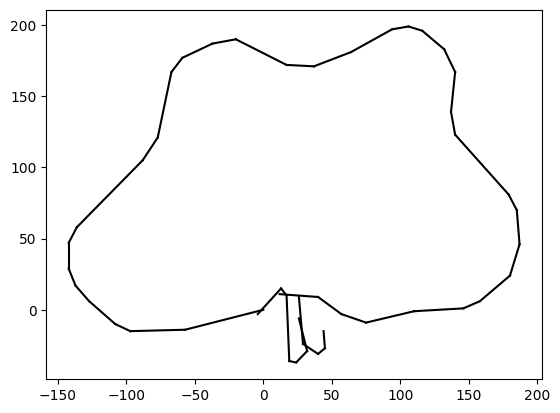

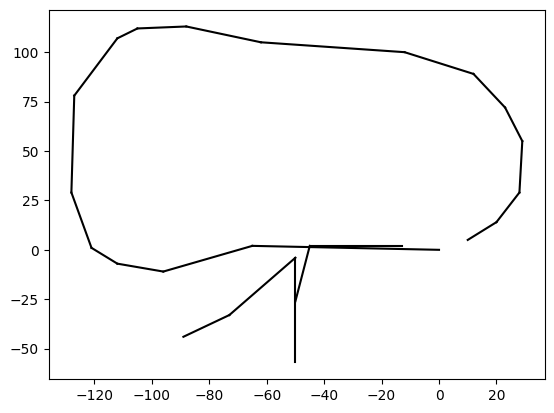

In [10]:
# plot the first 10 sketches

def plot_strokes_raw(strokes):
    plt.figure()
    x = 0
    y = 0
    plt.plot(x, y) # place the pen at the origin
    for i in range(len(strokes)):
        # ignore first stroke
        
        x += strokes[i, 0]
        y += strokes[i, 1]
        if not strokes[i, 2]: # if drawing, i,2 is pen up or down
            plt.plot([x - strokes[i, 0], x], [y - strokes[i, 1], y], 'k')
    plt.show()

for i in range(5):
    sketch = train[i]
    plot_strokes_raw(sketch)
    plt.show()
    

In [11]:
# check if gpu is available
print(cuda.gpu_enable)

True


In [12]:
try:
    import cupy as cp
    cupy = cp
    gpu_enable = True
except ImportError:
    gpu_enable = False

In [13]:
gpu_enable

True

In [14]:
import dezero
from dezero import cuda
from typing import List, Optional, Tuple, Any
import math

class StrokesDataset(dezero.DataLoader):
    def __init__(self, data, batch_size, max_seq_length: int, scale: Optional[float] = None, shuffle=True, gpu=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(data)
        self.max_iter = math.ceil(self.data_size / batch_size)
        
        xp = cupy if gpu_enable else np
        stroke_data = []
        
        for seq in data:
            # change to xp array
            # check seq type
            # we will deem a sequence that is less than 10 as too short and thus ignore it
            if 10 < len(seq) <= max_seq_length:
                # clamp the delta x and delta y to [-1000, 1000]
                seq = np.minimum(seq, 1000)
                seq = np.maximum(seq, -1000)
                
                seq = np.array(seq, dtype=np.float32)
                stroke_data.append(seq)
        
        if scale is None:
            # calculate the scale factor
            # the scale factor is the standard deviation of the x and y coordinates
            # mean is not adjusted for simplicity
            # 0:2 means the first two columns of the array which are x and y coordinates
            scale = np.std(np.concatenate([np.ravel(s[:,0:2]) for s in stroke_data]))
        
        longest_seq_len = max([len(seq) for seq in stroke_data])
        
        self.longest_seq_count = longest_seq_len + 1
        
        # we add two extra columns to the dataset since we currently there are only 3 columns in the dataset
        # additional two columns are for changing the last point 1/0 to a one-hot vector
        temp_stroke_dataset = np.zeros((len(stroke_data), longest_seq_len + 2, 5), dtype=np.float32)
        
        # self.mask is used to mark areas of the sequence that are not used
        # we first initialize it to zero
        temp_mask_dataset = np.zeros((len(stroke_data), longest_seq_len + 1))
        
        
        # start of sequence is [0, 0, 1, 0, 0]
        
        for i, seq in enumerate(stroke_data):
            seq = np.array(seq, dtype=np.float32)
            len_seq = len(seq)
            
            # we start from 1 to leave the first row for the start of sequence token
            temp_stroke_dataset[i, 1:len_seq + 1, 0:2] = seq[:, :2] / scale # this is the x and y coordinates
            temp_stroke_dataset[i, 1:len_seq + 1, 2] = 1 - seq[:, 2] # this is the pen down
            temp_stroke_dataset[i, 1:len_seq + 1, 3] = seq[:, 2] # this is the pen up
            temp_stroke_dataset[i, len_seq + 1, 4] = 1  # this is the end of sequence token
            temp_mask_dataset[i, :len_seq + 1] = 1 # mask is on until the end of the sequence 
            # self.mask is used to mark areas of the sequence that are not used
            # for example, if the sequence is shorter than the longest sequence, we use mask to ignore the rest of the sequence
            # an example of mask is [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        
        
        temp_stroke_dataset[:, 0, 2] = 1
        
        # self.dataset = xp.zeros((len(stroke_data), longest_seq_len + 2, 5), dtype=xp.float32)
        self.dataset = []
        
        for i in range(len(stroke_data)):
            self.dataset.append([temp_stroke_dataset[i], temp_mask_dataset[i]])
            # if self.dataset is None:
            #     self.dataset = F.expand_dims(temp_stroke_dataset[i], axis=0)
            # else:
            #     self.dataset = F.cat([self.dataset, F.expand_dims(temp_stroke_dataset[i], axis=0)], axis=0)

        self.reset()

    @property
    def longest_seq_len(self):
        return self.longest_seq_count
    

In [15]:
# is gpu?
gpu = dezero.cuda.gpu_enable
print(gpu)

True


In [16]:
strokes = StrokesDataset(train, batch_size=128, max_seq_length=200, gpu=False, shuffle=True)
longest_seq_len = strokes.longest_seq_len
print(longest_seq_len)

63


In [17]:
strokes.to_gpu()

In [18]:
# get location of strokes whether it is on gpu or cpu

print(len(strokes.dataset))
print(strokes.dataset[0][0].shape)
xp = cuda.cupy if gpu else np
print(xp.array(strokes.dataset[0][0]))

70000
(64, 5)
[[ 0.          0.          1.          0.          0.        ]
 [-0.5628141  -0.5959208   1.          0.          0.        ]
 [-0.62902755 -0.46349397  1.          0.          0.        ]
 [-1.0594149  -0.06621343  1.          0.          0.        ]
 [-0.43038726  0.16553356  1.          0.          0.        ]
 [-0.5628141   0.36417383  1.          0.          0.        ]
 [-0.2979604   0.36417383  1.          0.          0.        ]
 [-0.2979604   1.5891222   1.          0.          0.        ]
 [ 0.09932014  1.0594149   1.          0.          0.        ]
 [ 0.2979604   0.4966007   1.          0.          0.        ]
 [ 2.1188297   2.3174698   1.          0.          0.        ]
 [ 0.2979604   1.4898021   1.          0.          0.        ]
 [ 0.33106712  0.33106712  1.          0.          0.        ]
 [ 0.62902755  0.09932014  1.          0.          0.        ]
 [ 0.39728054 -0.4966007   1.          0.          0.        ]
 [ 0.72834766  0.          1.          0.

In [19]:
def plot_strokes_sequence(strokes):
    plt.figure()
    x = 0
    y = 0
    plt.plot(x, y)
    for i in range(len(strokes)):
        # ignore first stroke
        if i == 0:
            continue
        x += strokes[i, 0]
        y += strokes[i, 1]
        # the last three columns are pen down, pen up, and end of sequence
        if strokes[i, 2]:
            plt.plot([x - strokes[i, 0], x], [y - strokes[i, 1], y], 'k')
        elif strokes[i, 3]:
            # x = 0
            # y = 0
            continue
        elif strokes[i, 4]:
            break
    plt.show()

In [20]:
plot_strokes_sequence(test_batch[0].get())

NameError: name 'test_batch' is not defined

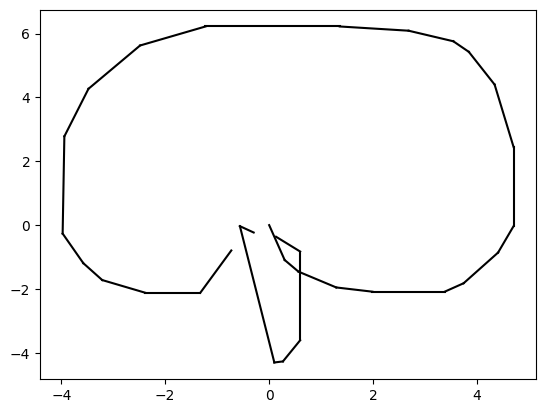

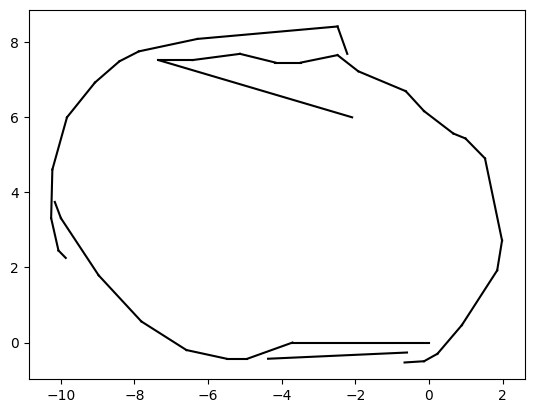

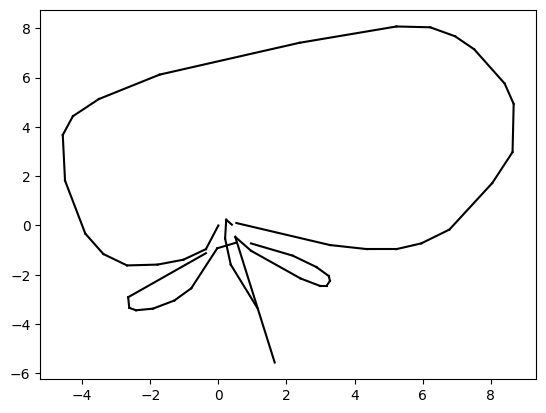

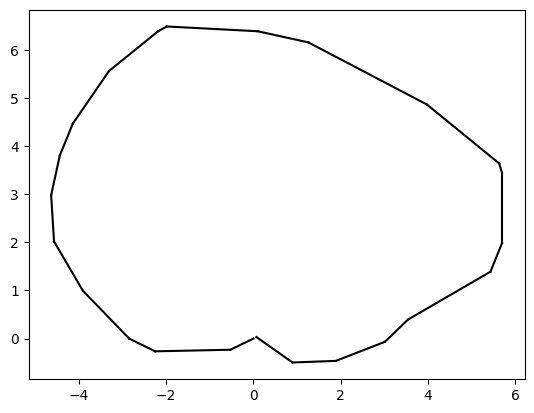

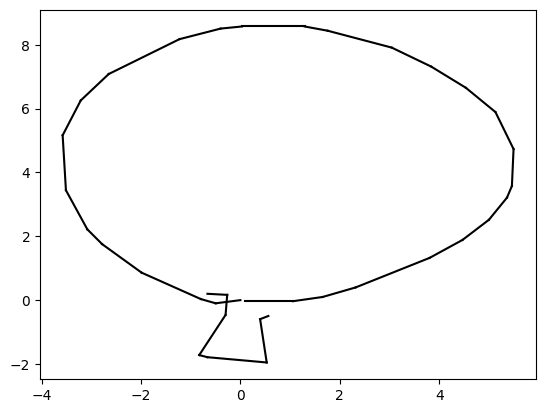

In [21]:

# do not care about the pen up and pen down
# print(plot[0])

for i in range(5):
    strokes.to_cpu()
    sample = next(strokes)
    batch = sample[0]
    plot = batch[0]
    plot_strokes_sequence(plot)


In [22]:
print(strokes.data_size)
# first item



x, t = strokes.__next__()
print(x.shape, t.shape) # x is the stroke, t is the mask (x has one more column than t)


# check if the mask is working
num_elemnts = x.shape[0]

for i in range(num_elemnts):
    mask_zero_id = np.where(t[i] == 0)[0]
    # first id
    first_id = mask_zero_id[0]
    stroke_end_id = np.where(x[i, :, 4] == 1)[0]
    first_stroke_end_id = stroke_end_id[0]
    
    print(first_id, first_stroke_end_id)


70000
(128, 64, 5) (128, 63)
45 45
40 40
29 29
38 38
29 29
38 38
38 38
49 49
43 43
44 44
57 57
33 33
55 55
39 39
36 36
32 32
45 45
28 28
47 47
56 56
30 30
32 32
29 29
52 52
46 46
29 29
32 32
51 51
27 27
47 47
27 27
61 61
32 32
36 36
35 35
56 56
41 41
54 54
40 40
37 37
33 33
38 38
39 39
37 37
49 49
31 31
40 40
28 28
36 36
46 46
40 40
42 42
27 27
31 31
27 27
61 61
45 45
37 37
41 41
48 48
30 30
37 37
45 45
38 38
31 31
43 43
29 29
30 30
26 26
49 49
37 37
46 46
59 59
52 52
32 32
50 50
52 52
59 59
36 36
29 29
38 38
57 57
33 33
30 30
28 28
41 41
31 31
38 38
43 43
35 35
42 42
29 29
32 32
36 36
34 34
47 47
40 40
35 35
31 31
25 25
31 31
33 33
52 52
53 53
26 26
33 33
32 32
43 43
41 41
53 53
32 32
51 51
35 35
53 53
44 44
26 26
29 29
23 23
45 45
45 45
37 37
41 41
41 41
26 26
33 33
29 29
39 39
48 48


In [23]:
import dezero.functions as F

# According to other estimates
# the number of distributions in the mixture model is 20
# https://github.com/Shun14/sketch-rnn-kanji
# https://nn.labml.ai/sketch_rnn/index.html

# This is for getting the loss of delta_x and delta_y
class BivariateGaussianMixture:
    def __init__(self, pi_logits, mu_x, mu_y, sigma_x, sigma_y, rho_xy):
        # check if the pi probabilities sum to 1
        self.pi_logits = pi_logits
        self.pi_probs = F.softmax(pi_logits, axis=-1)
        self.mu_x = mu_x # shape is (batch_size, seq_len, n_distributions)
        self.mu_y = mu_y
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.rho_xy = rho_xy
        self.temperature = 1.0
    
    @property
    def n_distributions(self):
        return self.pi_logits.shape[-1]
    
    def set_temperature(self, temperature: float):
        self.pi_logits /= temperature
        self.pi_probs = F.softmax(self.pi_logits, axis=2) # we do this to make sure the pi probabilities sum to 1
        self.sigma_x *= math.sqrt(temperature)
        self.sigma_y *= math.sqrt(temperature)

    
    def gaussian_pdf(self, x_delta, y_delta):
        # the result means the probability of y in the normal distribution
        # we check the probability of y in the normal distribution
        # if the probability is high, the result is close to 1
        # x_delta and y_delta shape are (batch_size, seq_len, hidden_size)
        # mu_x and mu_y shape are (batch_size, seq_len, n_distributions)
        
        norm1 = F.sub(x_delta, self.mu_x) # we subtract the mean from the x_delta
        norm2 = F.sub(y_delta, self.mu_y) # we subtract the mean from the y_delta
        xp = cuda.get_array_module(norm1)

        dtype = self.sigma_x.dtype
        max_dtype = xp.finfo(dtype).max
        self.sigma_x = F.clip(self.sigma_x, 1e-5, max_dtype)
        self.sigma_y = F.clip(self.sigma_y, 1e-5, max_dtype)
        self.rho_xy = F.clip(self.rho_xy, -1 + 1e-5, 1 - 1e-5)
        
        s1s2 = F.mul(self.sigma_x, self.sigma_y) # sls is the product of the standard deviations
        
        # This is from: https://github.com/hardmaru/write-rnn-tensorflow/blob/master/model.py
        # z = tf.square(tf.div(norm1, s1)) + tf.square(tf.div(norm2, s2))
        #     - 2 * tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2)
         
        # below is the deconstruction of the above linez
        z_first_term = F.pow(F.div(norm1, self.sigma_x), 2)
        z_second_term = F.pow(F.div(norm2, self.sigma_y), 2)
        z_last_term_inner = F.mul(self.rho_xy, F.mul(norm1, norm2))
        z_last_term_middle = F.div(z_last_term_inner, s1s2)
        tmp_z = xp.ones(z_last_term_middle.shape) * -2
        z_last_term = F.mul(tmp_z, z_last_term_middle)
        z = F.add(F.add(z_first_term, z_second_term), z_last_term)
        negRho = F.sub(xp.ones(self.rho_xy.shape), F.pow(self.rho_xy, 2))

        
        result = F.exp(F.div(-z, 2 * negRho))
        deno_first_term = xp.ones(self.sigma_x.shape) * 2 * math.pi
        denom_second_term = F.mul(s1s2, F.pow(negRho, 0.5))
        denom = F.mul(deno_first_term, denom_second_term)
        result = F.div(result, denom) # result is the probability of y in the normal distribution
        
        return result

    # x1_data and x2_data are the real x and y coordinates of the stroke
    def get_lossfunc(self, x_delta, y_delta, mask):
        
        xp = cuda.get_array_module(x_delta)
        result0 = self.gaussian_pdf(x_delta, y_delta)
        
        
        # check if result0 has inf or nan
        # result0 shape is (batch_size, seq_len, n_distributions) 3D
        result1 = F.mul(result0, self.pi_logits) # pi_logits shape is (batch_size, seq_len, n_distributions)
        
        result1 = F.sum(result1, axis=2, keepdims=True) # sum over the distributions
        # the result1 shape is (batch_size, seq_len, 1)
        # we reshape it to (batch_size, seq_len)
        result1 = F.reshape(result1, result1.shape[:-1]) # result.shape[:-1] is (batch_size, seq_len)
        
        dtype = result1.dtype
        max_dtype = xp.finfo(dtype).max
        result1 = F.clip(result1, 1e-5, max_dtype) 
        # the higher the result1, the lower the loss (= the more likely the stroke is)

        result1 = -F.log(result1) # result1 shape is (batch_size, seq_len)
        # mask shape is also (batch_size, seq_len)
        result1 = F.mul(result1, mask) # we multiply the mask to ignore the padding
        
        
        # result1 is the negative log likelihood
        
        return F.mean(result1)
    
    # get_pi_idx is used to get the index of the distribution
    def get_pi_idx(self, x, out_pi_elem):
        # pdf shape is (batch_size, seq_len, n_distributions)
        # let us only get the first batch
        pdf = out_pi_elem
        N = pdf.size # pdf size is the number of distributions
        accumulate = 0
        # print(pdf.size, 'pdf size')
        # print(F.sum(pdf), 'sum of pdf')
        # print(out_pi_elem.shape, 'out_pi_elem shape')
        # print(x, 'x in pi idx', pdf, " pdf", pdf.shape)
        # print("hello",pdf[0], x)
        for i in range(0, N):
            # print(pdf[i].data, 'pdf[i].data')
            accumulate += pdf[i].data
            if accumulate >= x:
                return i
            # print(accumulate, 'accumulate')
        print('error with sampling ensemble')
        return -1
    
    # since this one will not be used for training, we can use numpy
    def sample_bivariate_normal(self):
        mean = [self.mu_x, self.mu_y]
        cov = [[self.sigma_x * self.sigma_x, self.rho_xy * self.sigma_x * self.sigma_y],\
            [self.rho_xy * self.sigma_x * self.sigma_y, self.sigma_y * self.sigma_y]]
        x = np.random.multivariate_normal(mean, cov, 1)
        return x[0][0], x[0][1]
    
    # M means the number of samples
    def sample(self, num_elemnts, M=15):
        # batch_size should be not be bigger than mu_x.shape[1]
        xp = cuda.cupy if gpu_enable else np
        # get the index of the distribution
        
        # we will get a randomized number between 0 and 1 for a shape of (count, M, 3)
        # count represents the number of sequences we want to get
        # M represents the number of samples we want to get
        result = xp.random.rand(num_elemnts, M, 3) # initially random [0,1]
        # print(result.shape, 'result shape')
        # we will get result for delta_x and delta_y
        rn = xp.random.rand(num_elemnts, M, 2) 
        mu = 0
        std = 0
        idx = 0
        
        # currently the pi logits shape is (batch_size, seq_len, n_distributions)
        # we will only get the first batch for now'
        # print(self.pi_logits.shape, 'pi logits shape')
        # print(self.pi_logits[0].shape, 'pi logits shape')
        # print("get sum of pi", F.sum(self.pi_logits[0]))
        
        # out_pi has the information of the distributions 
        out_pi = self.pi_probs[0] # out_pi shape is (seq_len, n_distributions)
        # for each sequence, we will get the weights of the n distributions
        # print(out_pi.shape, 'out_pi shape')
        # print("mu_x", self.mu_x.shape)
        # print("std", self.sigma_x.shape)
        
        # we do not need to get batch size since we are only getting the first batch
        # mu_x has the shape of (batch_size, seq_len, n_distributions)
        # if we only get the first batch, then shape of mu_x is (seq_len, n_distributions)
        mu_x = self.mu_x[0]
        mu_y = self.mu_y[0]
        sigma_x = self.sigma_x[0]
        sigma_y = self.sigma_y[0]
        rho_xy = self.rho_xy[0]
        
        if gpu_enable:
            mu_x = mu_x.data.get()
            mu_y = mu_y.data.get()
            sigma_x = sigma_x.data.get()
            sigma_y = sigma_y.data.get()
            rho_xy = rho_xy.data.get()
        
        for j in range(M):
            # M is the number of samples we want to get for each batch
            for i in range(num_elemnts): # count is the batch size
                # if count is 1, we will only get the first batch
                # rn is the random number between 0 and 1
                idx = self.get_pi_idx(result[i, j, 0], out_pi[i])
                # get_pi_idx will return the index of the corresponding distribution
                mu = xp.array([mu_x[i, idx], mu_y[i, idx]])
                std = xp.array([sigma_x[i, idx], sigma_y[i, idx]])
                rho = rho_xy[i, idx]
                
                # we will get the x and y coordinates
                result_x_y = (mu + rn[i, j] * std)
                result[i, j, 0] = result_x_y[0]
                result[i, j, 1] = result_x_y[1]
                
                
                # for calculating the probability of the x and y coordinates
                # we need to stack the x and y coordinates
                
                
                # we will get the probability of the x and y coordinates
                # stacked_x = None
                # stacked_y = None
                
                # x = F.expand_dims(xp.array([result_x_y[0]]), axis=0)
                # y = F.expand_dims(xp.array([result_x_y[1]]), axis=0)
                
                # for i in range(self.n_distributions):
                #     if stacked_x is None:
                #         stacked_x = F.expand_dims(x, axis=2)
                #         stacked_y = F.expand_dims(y, axis=2)
                #     else:
                #         stacked_x = F.cat((stacked_x, F.expand_dims(x, axis=2)), axis=2)
                #         stacked_y = F.cat((stacked_y, F.expand_dims(y, axis=2)), axis=2)
        
                # prob = self.gaussian_pdf(stacked_x, stacked_y)
                # print("prob", prob)
                # result[i, j, 2] = prob.data # this will be the resulting probability of the x and y coordinates
        return result
        
        

        

In [24]:
import dezero.models as M
import dezero.layers as L

class EncoderRNN(M.Model):
    # d_z is the number of dimensions of the latent variable
    def __init__(self, d_z, enc_hidden_size):
        super().__init__()
        self.lstm = L.LSTM(in_size=5, hidden_size=enc_hidden_size) # number of input for lstm is 5
        self.mu_head = L.Linear(in_size=enc_hidden_size, out_size=d_z) # why enc_hidden_size?
        self.sigma_head = L.Linear(in_size=enc_hidden_size, out_size=d_z)
    
    
    def forward(self, x, state=None):
        xp = cuda.get_array_module(x)
        
        seq_len = x.shape[1]
        
        # https://velog.io/@sjinu/Pytorch-Implementation-code
        h, c = None, None
        for i in range(seq_len):
            if h is None or c is None:
                h, c = self.lstm(x[:, i, :])
            else:
                h, c = self.lstm(x[:, i, :], h, c)

        # the size of h is (batch_size, hidden_size)
        mu = self.mu_head(h)
        
        sigma_hat = self.sigma_head(h)
        
        sigma = F.exp(F.div(sigma_hat, 2))
        
        z = mu + sigma * xp.random.normal(0, 1, mu.shape) # reparameterization trick
        
        # the shape of z is (batch_size, d_z)
        
        return z, mu, sigma
    
    def reset_state(self):
        self.lstm.reset_state()

In [25]:
class DecoderRNN(M.Model):
    def __init__(self, d_z: int, dec_hidden_size: int, n_distributions: int, longest_seq_len: int):
        super().__init__()
        # we add 5 to the input size because we are adding the latent variable to the input
        self.lstm = L.LSTM(in_size=d_z+5, hidden_size=dec_hidden_size)
        # self.init_state = L.Linear(2 * dec_hidden_size, False, np.float32, d_z) # initial state of lstm is [h0;c0] = tanh(Wz * z + bz)
        self.init_h_state = L.Linear(in_size=d_z, out_size=dec_hidden_size)
        self.init_c_state = L.Linear(in_size=d_z, out_size=dec_hidden_size)
        self.longest_seq_len = longest_seq_len
        
        
        # self.mixtures = L.Linear(6 * n_distributions, False, np.float32, dec_hidden_size)
        # torch linear accepts arbitrary input size (not just 2d) 
        # https://stackoverflow.com/questions/67006014/working-of-nn-linear-with-multiple-dimensions
        
        self.pi_logit_mixtures = L.Linear(in_size=dec_hidden_size, out_size=n_distributions)
        self.mu_x_mixtures = L.Linear(in_size=dec_hidden_size, out_size=n_distributions)
        self.mu_y_mixtures = L.Linear(in_size=dec_hidden_size, out_size=n_distributions)
        self.sigma_x_mixtures = L.Linear(in_size=dec_hidden_size, out_size=n_distributions)
        self.sigma_y_mixtures = L.Linear(in_size=dec_hidden_size, out_size=n_distributions)
        self.rho_xy_mixtures = L.Linear(in_size=dec_hidden_size, out_size=n_distributions)
        # 아래 것이 해결 안됨
        self.q_head = L.Linear(in_size=dec_hidden_size, out_size=3) # this is for logit q1 and q2 and q3
 
        
        self.n_distributions = n_distributions
        self.n_hidden = dec_hidden_size
    
    # x is the stroke data
    # z is the latent variable passed from the encoder
    def forward(self, x, z, h=None, c=None):
        xp = cuda.get_array_module(x)
        
        if h is None or c is None:
            # temp = F.tanh(self.init_state(z))
            h = F.tanh(self.init_h_state(z))
            c = F.tanh(self.init_c_state(z))
            
            # split the state into h and c into n_hidden groups
            # torch split and numpy split are different!!
            # print(temp)
            # h, c = xp.split(temp.data, temp.shape[-1] / self.n_hidden, axis=1)
            # print(h,c)
        
        outputs = None
        seq_len = x.shape[1]
        
        
        for i in range(seq_len):
            h, c = self.lstm(x[:, i, :], h, c)
            # concat hidden to outputs
            expanded_h = F.expand_dims(h, axis=1)
            if outputs is None:
                outputs = expanded_h
            else:
                outputs = F.cat((outputs, F.expand_dims(h, 1)), axis=1)
        
        # state = (h,c)
        
        outputs= F.reshape(outputs, (-1, self.n_hidden)) # we need to resize the outputs to make it compatible with the linear layer
        
        q_logits = F.log_softmax(self.q_head(outputs))
        
        # print(self.mixtures(outputs).shape, "output mixtures")
        
        # pi_logts, mu_x, mu_y, sigma_x, sigma_y, rho_xy = xp.split(self.mixtures(outputs), 6, axis=2)
        
        # output size is (batch_size, seq_len, dec_hidden_size)
        # (4, 100, 512)
        
        # pi_logits size is (batch_size, seq_len, n_distributions)
        
        
        # https://github.com/pytorch/pytorch/blob/31232061aa4779c7db5ebb2d9f89c75cea77c177/aten/src/ATen/native/LinearAlgebra.cpp#L439
        # we will flatten the outputs to make it compatible with the linear layer
        
        pi_logits = self.pi_logit_mixtures(outputs)
        mu_x = self.mu_x_mixtures(outputs)
        mu_y = self.mu_y_mixtures(outputs)
        sigma_x = self.sigma_x_mixtures(outputs)
        sigma_y = self.sigma_y_mixtures(outputs)
        rho_xy = self.rho_xy_mixtures(outputs)
        
        
        # we reshape the outputs to the original shape
        # for each sequence, we get the parameters of the mixture model
        pi_logits = F.reshape(pi_logits, (-1, seq_len, self.n_distributions))
        mu_x = F.reshape(mu_x, (-1, seq_len, self.n_distributions))
        mu_y = F.reshape(mu_y, (-1, seq_len, self.n_distributions))
        sigma_x = F.reshape(sigma_x, (-1, seq_len, self.n_distributions))
        sigma_y = F.reshape(sigma_y, (-1, seq_len, self.n_distributions))
        rho_xy = F.reshape(rho_xy, (-1, seq_len, self.n_distributions))
        
        
        
        q_logits = F.reshape(q_logits, (-1, seq_len, 3))
        
        
        # pi_logits are the logits of the mixture model
        # we need to change logits to probabilities
        
        # the values of 20 distributions must sum to 1
        # pi_probs = F.softmax(pi_logits, axis=2) # axis 2 is the innermost axis  
        # check if the first sequence has the sum of 1
        # print(pi_probs[0].shape, 'pi probs shape 1st seq')
        # print(F.sum(pi_probs[0][0]), 'sum of pi probs 1st seq')
        
        # print('test pi', test_pi.shape) # pi shape is (batch_size, seq_len, n_distributions)
        # check if the pi probabilities sum to 1
        # print(F.reshape(F.sum(test_pi, axis=2), (-1, seq_len)), 'sum of pi')
        
        BGM = BivariateGaussianMixture(pi_logits, mu_x, mu_y, F.exp(sigma_x), F.exp(sigma_y), F.tanh(rho_xy))
        
        return BGM, q_logits, h, c

In [26]:


class ReconstructionLoss(M.Model):
    # mask is the mask for the sequence,
    # for example, [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]: this means the first 3 points are used
    def forward(self, mask, target, bgm, q_logits):
        xp = cuda.get_array_module(mask)
        # target is a 3 dimensional array
        # xy = target[:, :, 0:2].unsqueeze(-2).expand(-1, -1, dist.n_distributions, -1)
        xy = target[:, :, 0:2]
        x = xy[:, :, 0]
        y = xy[:, :, 1]
        distributions = bgm.n_distributions
        stacked_x = None
        stacked_y = None
        for i in range(distributions):
            if stacked_x is None:
                stacked_x = F.expand_dims(x, axis=2)
                stacked_y = F.expand_dims(y, axis=2)
            else:
                stacked_x = F.cat((stacked_x, F.expand_dims(x, axis=2)), axis=2)
                stacked_y = F.cat((stacked_y, F.expand_dims(y, axis=2)), axis=2)
        
        # expanded_shape = (xy.shape[0], xy.shape[1], bgm.n_distributions, xy.shape[3])
        
        
        # x = xp.tile(xy, expanded_shape)
        # y = xp.tile(xy, expanded_shape)
        # loss_stroke 에 문제
        
        loss_stroke = bgm.get_lossfunc(stacked_x, stacked_y, mask)
        
        loss_pen = -F.mean(F.mul(target[:,:,2:], q_logits))
        
        return F.add(loss_stroke, loss_pen)
        

In [27]:
class KLDivergenceLoss(M.Model):
    def forward(self, mu, sigma):
        xp = cuda.get_array_module(mu)
        tmp = xp.ones(sigma.shape)
        inner_1 = F.add(tmp, sigma)
        inner_2 = F.add(F.pow(mu, 2), F.exp(sigma))
        inner = F.sub(inner_1, inner_2)
        tmp2 = xp.ones(inner.shape) * -2
        return F.mean(F.div(inner, tmp2))
        

In [28]:
# train

enc_hidden_size = 256
dec_hidden_size = 512

num_elemnts = 1
# Number of features in z (latent variable)
d_z = 128
n_distribution = 20
kl_div_loss_weight = 0.5
grad_clip = 1.0
temperature = 0.4
max_seq_length = 200

epochs = 20

kl_div_loss = KLDivergenceLoss()
recon_loss = ReconstructionLoss()


In [29]:
input = np.random.randn(4, 4)
stacked = np.stack([input, input, input, input], axis=0)

# First, expand the dimensions of the input array to create a new axis for stacking
expanded_input = np.expand_dims(input, axis=0)

n = 4
# Use np.tile to repeat the array along the new axis
stacked = np.tile(expanded_input, (n, 1, 1))

print(stacked.shape)

(4, 4, 4)


In [30]:
print(tuple([1,2,3,4]))

print(np.concatenate(([1],[2],[3],[4])))

(1, 2, 3, 4)
[1 2 3 4]


In [31]:
# the below link has the code for VAE
# https://github.com/alexis-jacq/Pytorch-Sketch-RNN/blob/master/sketch_rnn.py

import weakref

class SketchVAE(M.Model):
    def __init__(self, d_z, enc_hidden_size, dec_hidden_size, longest_seq_len):
        super().__init__()
        self.encoder = EncoderRNN(d_z, enc_hidden_size)
        self.decoder = DecoderRNN(d_z, dec_hidden_size, n_distribution, longest_seq_len)
    
    def forward(self, x, t):
        # x is the stroke data
        # t is the mask
        xp = cuda.get_array_module(x)
        z, mu, sigma = self.encoder(x)
        
        seq_len = x.shape[1]
        
        
        # expand the dimensions of z to match the dimensions of x
        expanded_z = F.expand_dims(z, axis=1)
        z_stack = None
        for i in range(seq_len-1):
            if i == 0:
                z_stack = expanded_z
            else:
                z_stack = F.cat((z_stack, expanded_z), axis=1)
        
        # z_stack = np.tile(z[:, np.newaxis, :], (1, seq_len, 1))

        # x_shape[0] is the batch size
        
        # x[:,:-1] means all the sequences except the last one
        inputs = F.cat((x[:,:-1], z_stack), axis=2)
        
        # the input shape must be (batch_size, seq_len, 5)
        bgm, q_logits, h, c = self.decoder(inputs, z)
        
        kl_loss = kl_div_loss(mu, sigma)
        rec_loss = recon_loss(t, x[:,1:], bgm, q_logits)
        
        return kl_loss + rec_loss
    
    def reset_state(self):
        self.lstm.reset_state()

    # conditional generation is on one sequence
    def conditional_generation(self, inputs):

        
        longest_seq_len = inputs.shape[1]

        
        xp = cuda.cupy if gpu_enable else np
        
        z, _, _ = self.encoder(inputs)
        
        # get only the first z batch
        z_count = z.shape[0]
        if z_count > 1:
            z = F.expand_dims(z[0], axis=0)

        
        # z_shape is (batch_size, d_z) = (1, d_z)
        seq_len = inputs.shape[1]
        seq_x = []
        seq_y = []
        seq_pen = []
        
        sos = xp.zeros(5)
        sos[2] = 1
        s = sos
        
        seq = xp.array([s])
        
        h = None
        c = None
        
        with dezero.no_grad():
            for i in range(longest_seq_len):
                # we must make s a batch (1, 1, 5)
                morphed_s = F.reshape(seq[-1], (1, 1, -1))
                dec_inputs = F.cat((morphed_s, F.expand_dims(z, axis=0)), axis=2)
            
                if h is None or c is None:
                    bgm, q_logits, h, c = self.decoder(dec_inputs, z)
                else:
                    bgm, q_logits, h, c = self.decoder(dec_inputs, z, h, c)
                # sample
                
                s = bgm.sample(1) # x, y
                
                s = s[0, 0, :][0:2] # 0:2 means we only get the x and y coordinates
                
                
                q_props = F.softmax(q_logits, axis=-1) # q_logits size is (batch_size, seq_len, 3)
            
                
            
                
                q_choice = xp.random.choice(3, 1, p=q_props[0, 0, :].data)
                
                qs = xp.zeros(3)
                
                qs[q_choice] = 1
                
                # size of q_choice is (1,)
                
                # we must make s a batch (1, 1, 5)
                
                
                s = F.cat((s, qs))
                
                
                
                
                seq = F.cat((seq, F.expand_dims(s, axis=0)), axis=0)
                if s[4] == 1:
                    break
        
        if gpu_enable:
            return seq.data.get()
        
        return seq
        

In [32]:
len(test_batch[0])

NameError: name 'test_batch' is not defined

is cuda enabled True
starting epoch 0
Epoch 0.0 Iteration 0 loss: inf


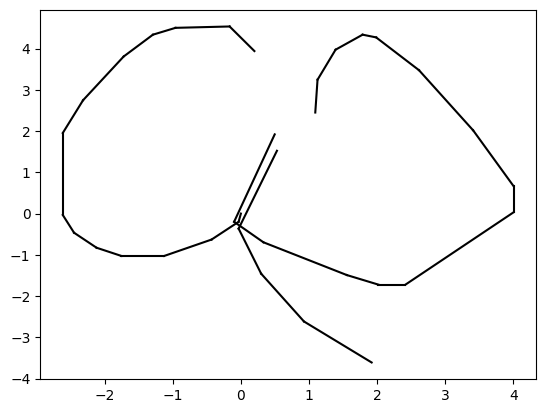

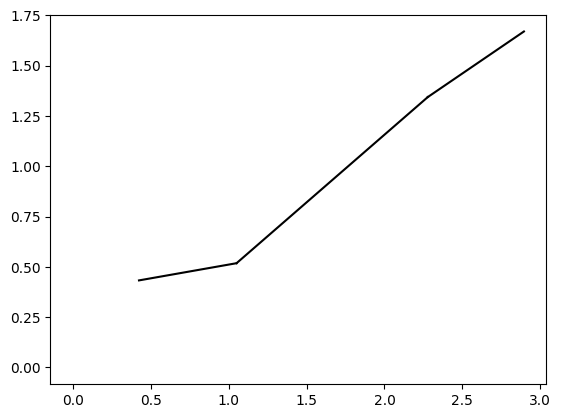

Epoch 0.018281535648994516 Iteration 10 loss: 3.319638192763005


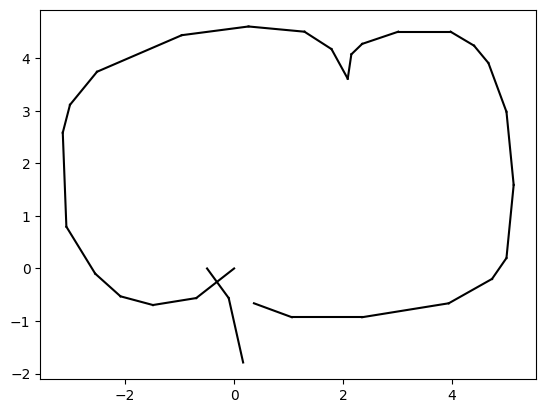

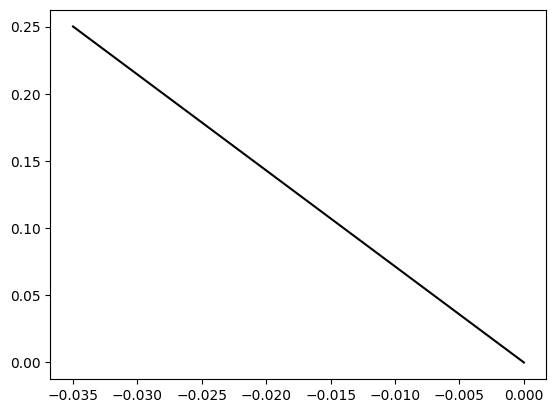

Epoch 0.03656307129798903 Iteration 20 loss: 1.8302767372161601


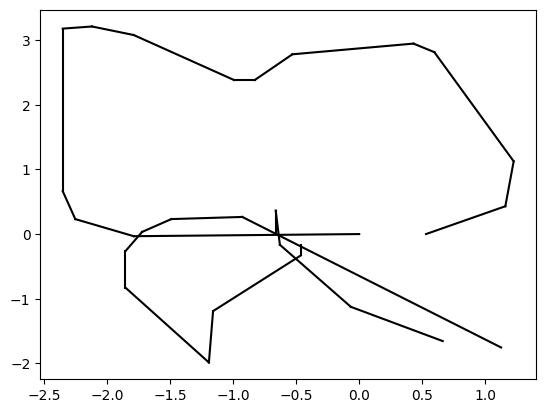

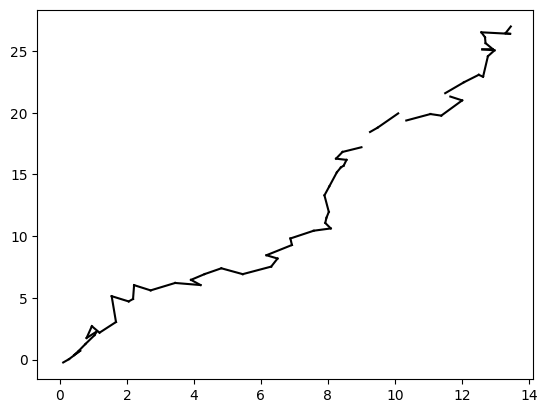

Epoch 0.054844606946983544 Iteration 30 loss: 1.0714499938634499


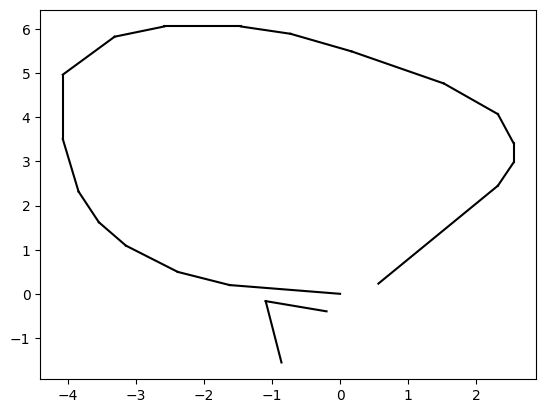

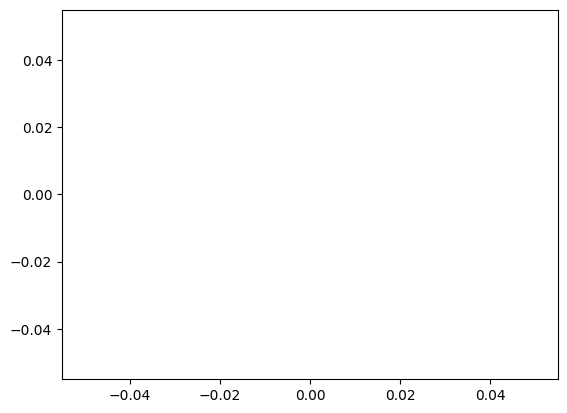

Epoch 0.07312614259597806 Iteration 40 loss: 0.5762741802722731


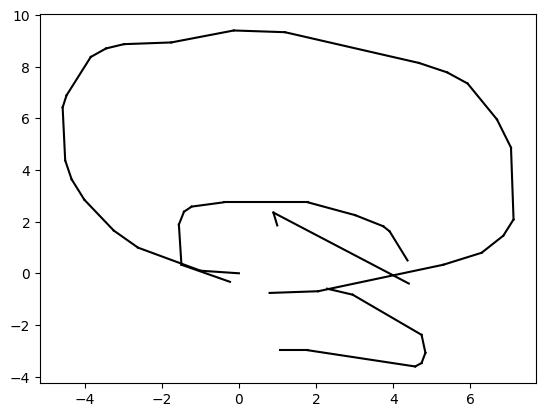

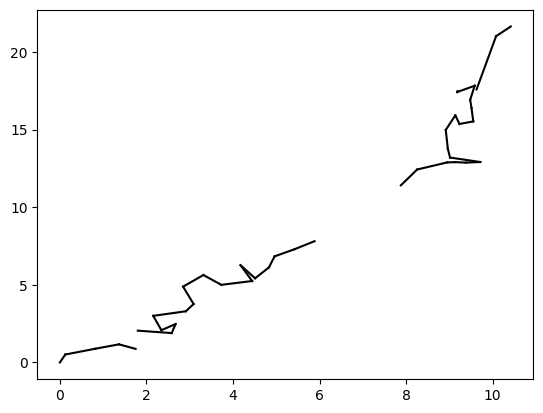

Epoch 0.09140767824497258 Iteration 50 loss: 0.22823544694906012


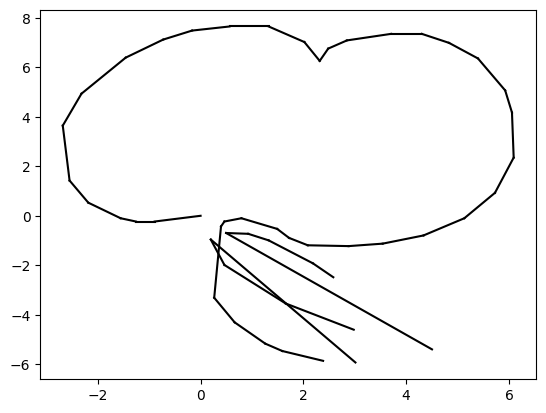

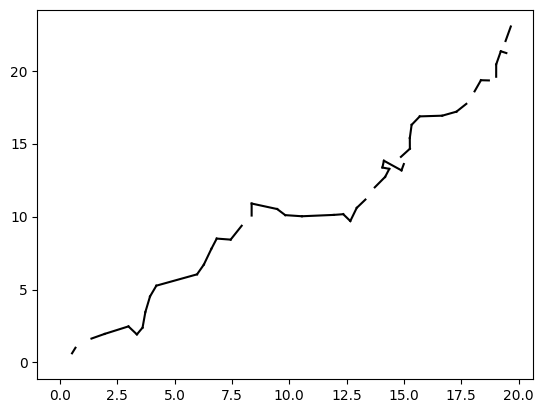

Epoch 0.10968921389396709 Iteration 60 loss: -0.0329644480317237


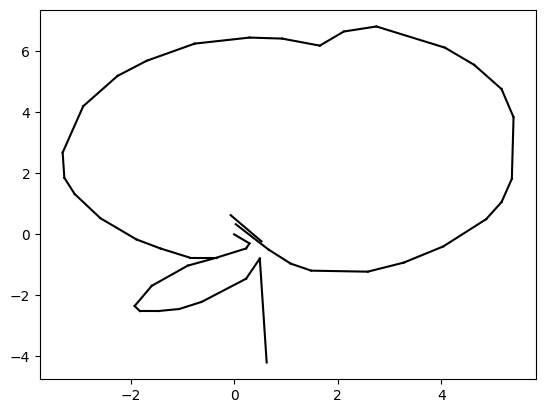

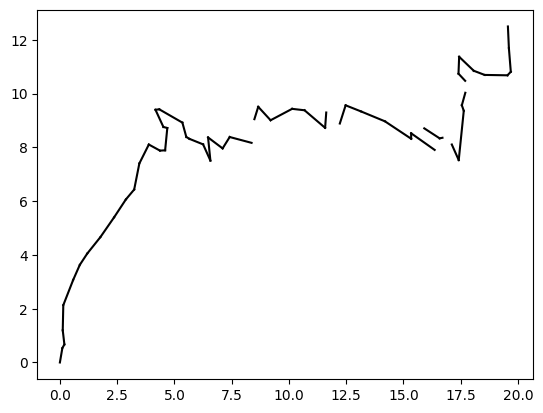

Epoch 0.12797074954296161 Iteration 70 loss: -0.24206820911615326


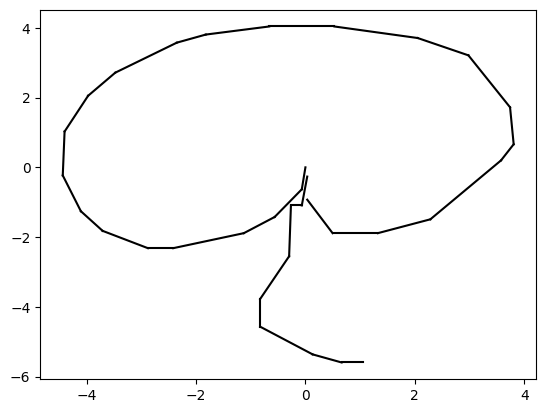

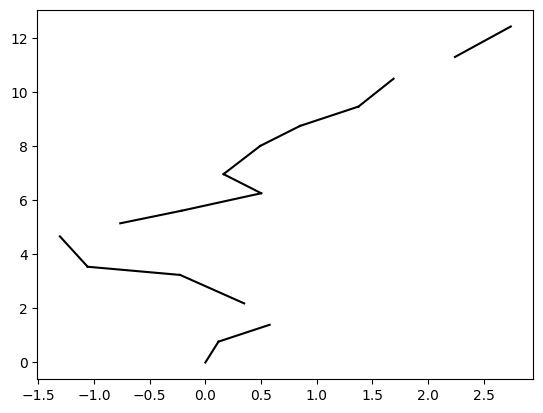

Epoch 0.14625228519195613 Iteration 80 loss: -0.4116583041465134


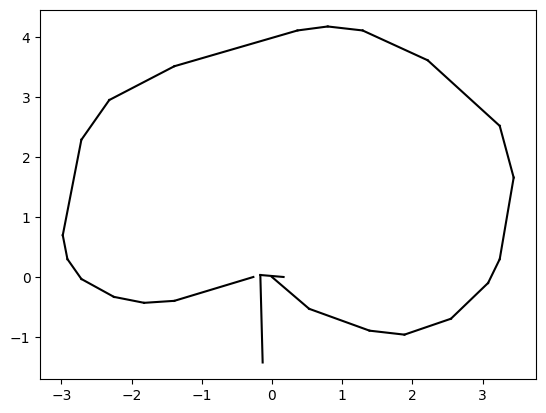

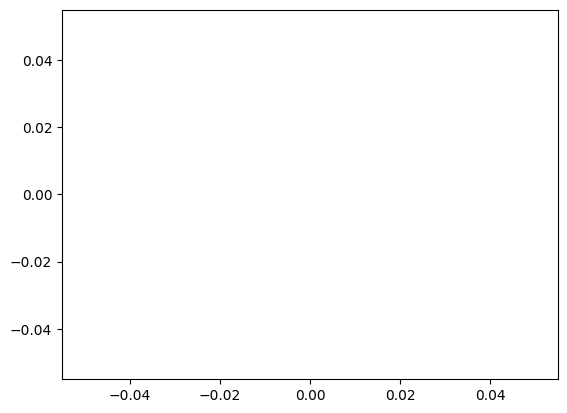

Epoch 0.16453382084095064 Iteration 90 loss: -0.5544408500924783


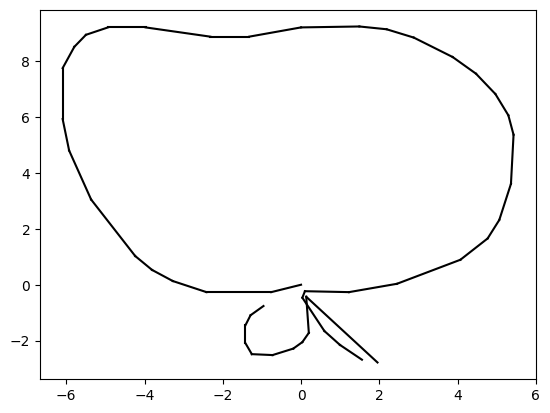

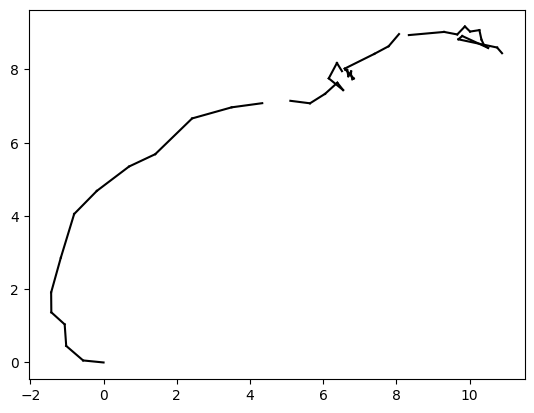

Epoch 0.18281535648994515 Iteration 100 loss: -0.6798154039787984


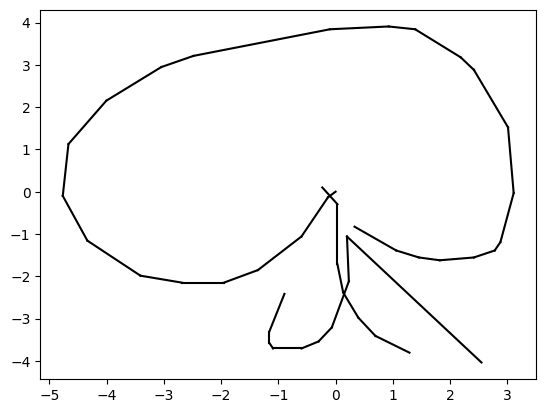

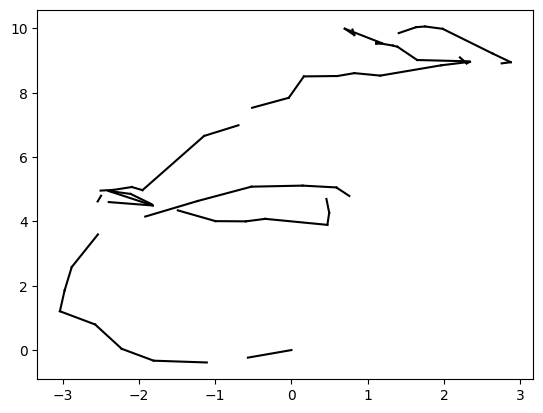

Epoch 0.20109689213893966 Iteration 110 loss: -0.7909580646701596


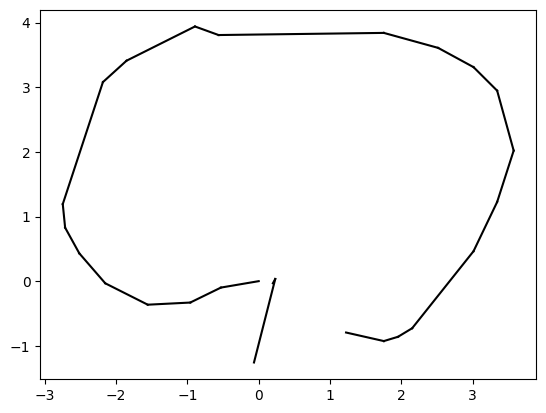

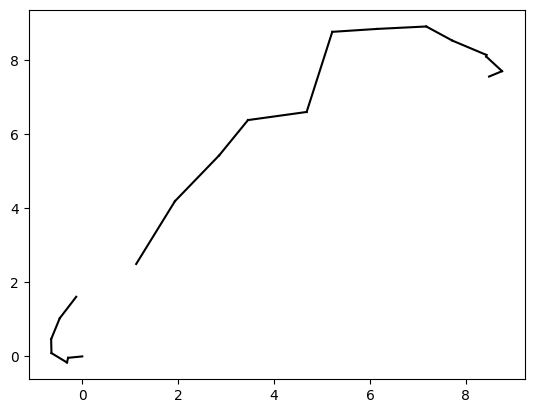

Epoch 0.21937842778793418 Iteration 120 loss: -0.8907034431210074


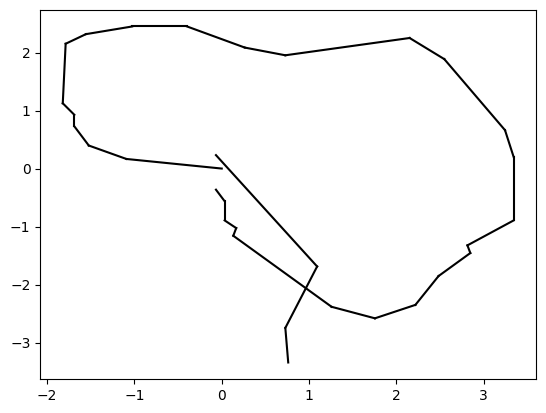

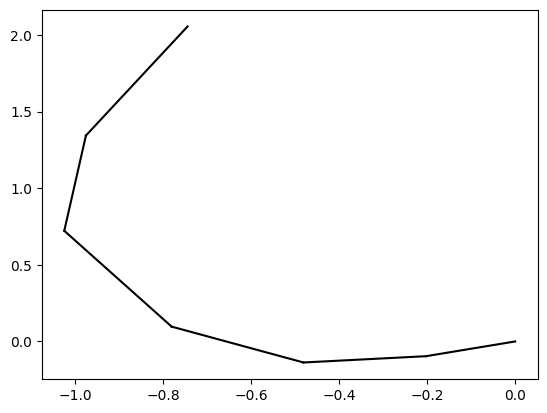

Epoch 0.2376599634369287 Iteration 130 loss: -0.981712291460983


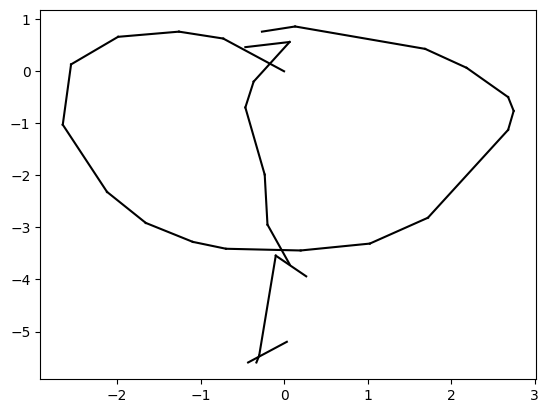

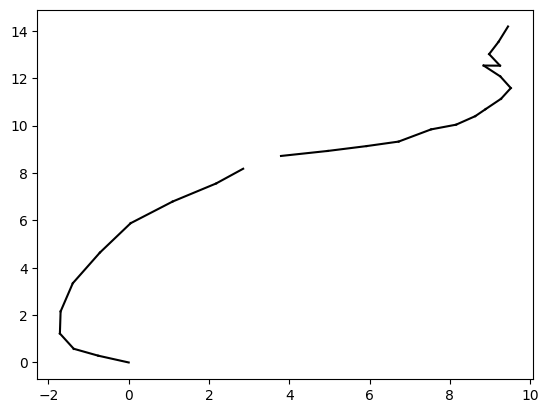

Epoch 0.25594149908592323 Iteration 140 loss: -1.0583605380194265


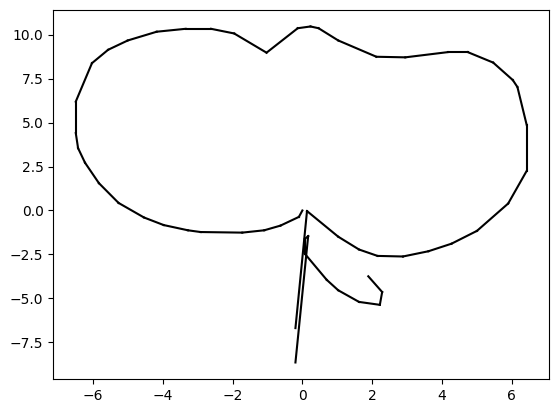

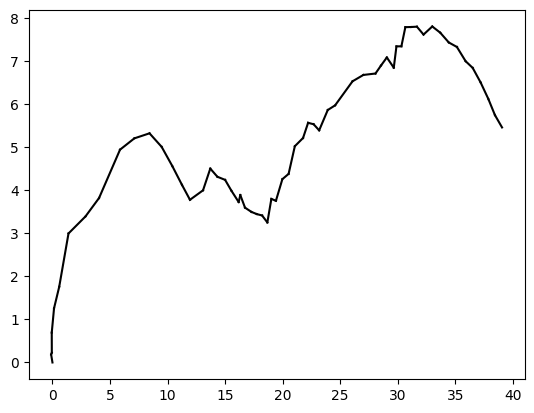

Epoch 0.2742230347349177 Iteration 150 loss: -1.1311323339708867


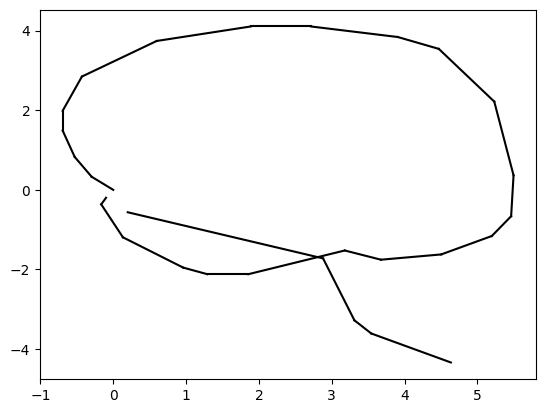

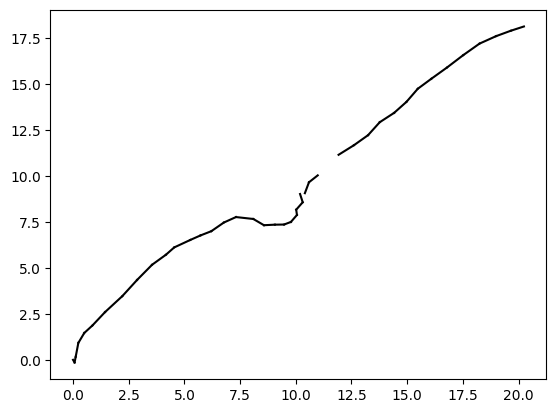

Epoch 0.29250457038391225 Iteration 160 loss: -1.198125316069335


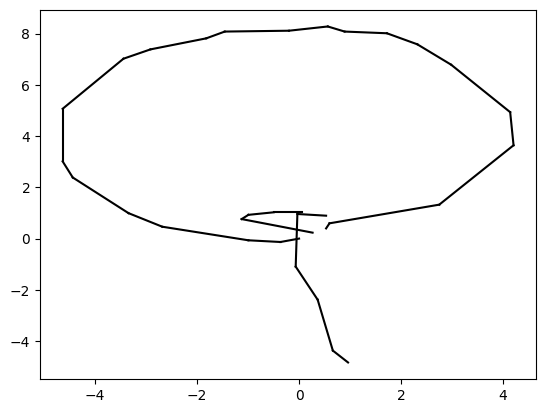

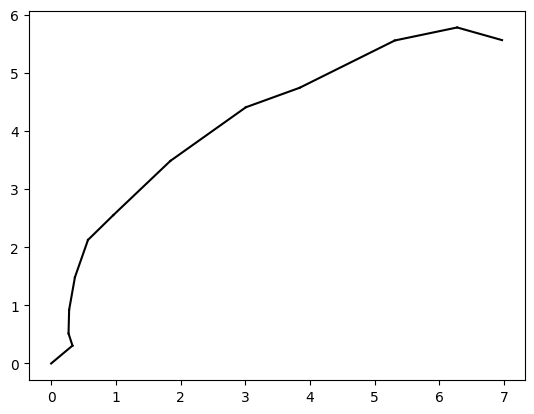

Epoch 0.31078610603290674 Iteration 170 loss: -1.2630107848363379


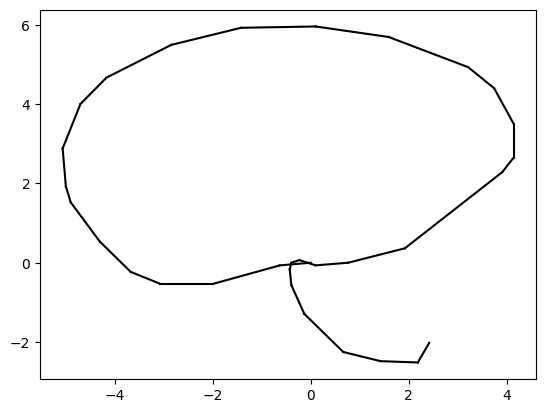

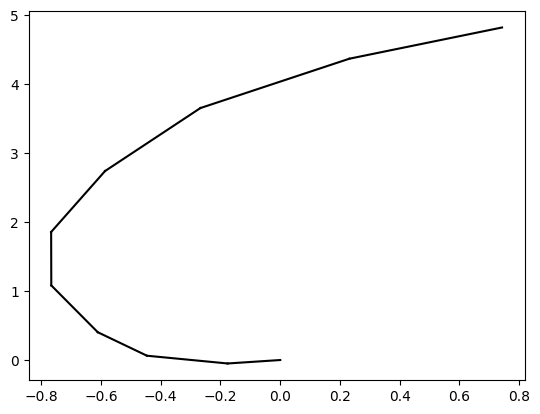

Epoch 0.3290676416819013 Iteration 180 loss: -1.321599297931289


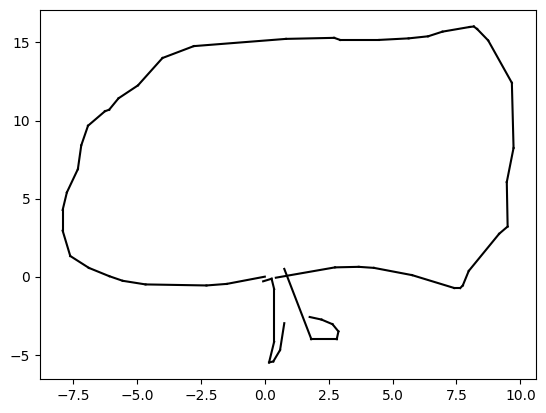

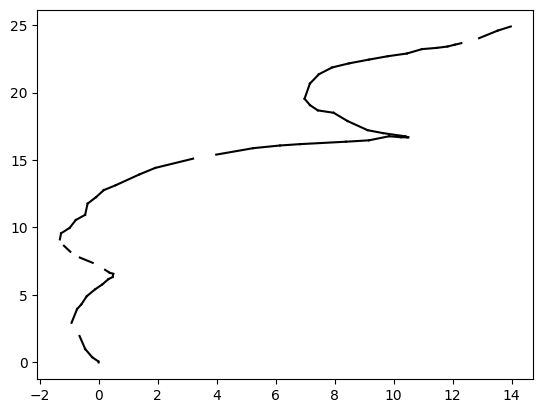

Epoch 0.3473491773308958 Iteration 190 loss: -1.37817840737429


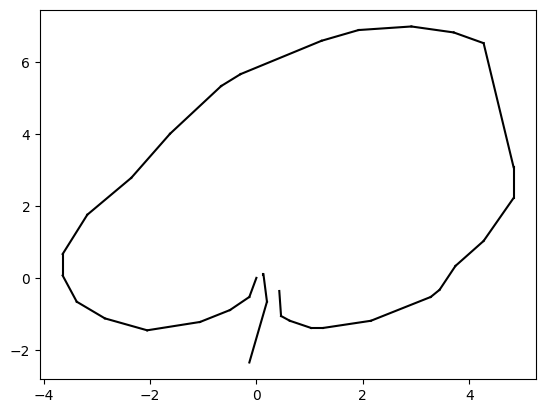

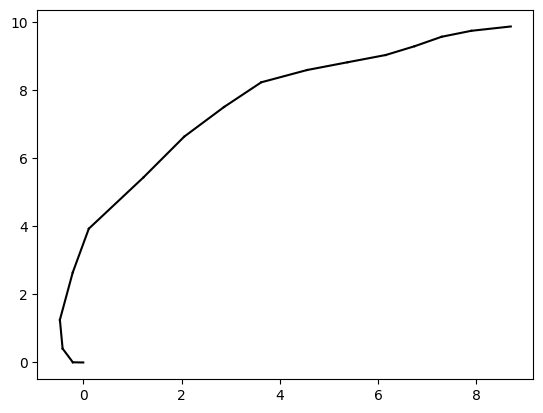

Epoch 0.3656307129798903 Iteration 200 loss: -1.4311445227078408


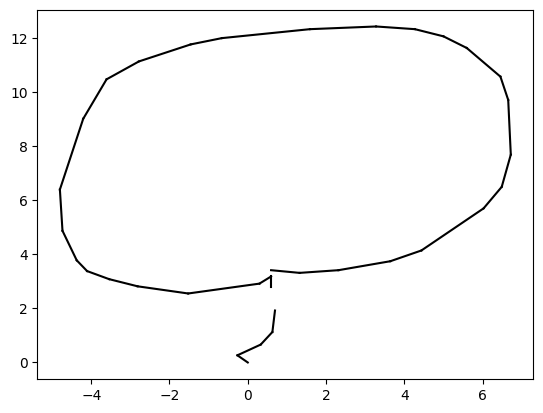

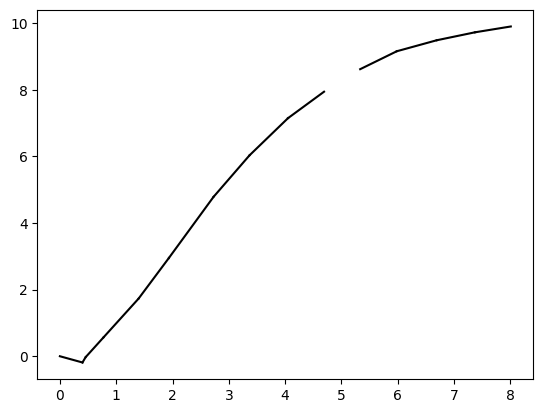

Epoch 0.38391224862888484 Iteration 210 loss: -1.481545279086233


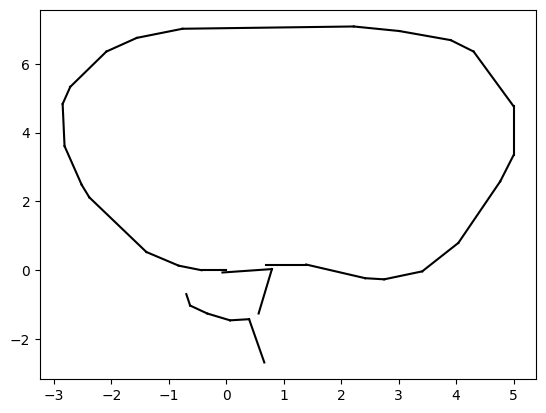

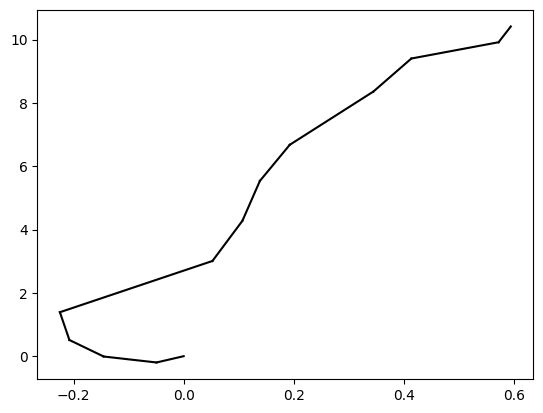

Epoch 0.40219378427787933 Iteration 220 loss: -1.5306399888688191


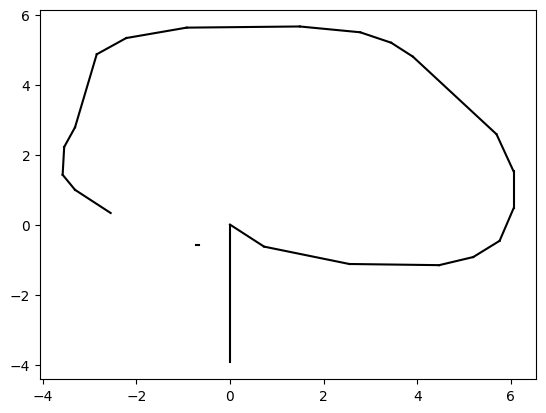

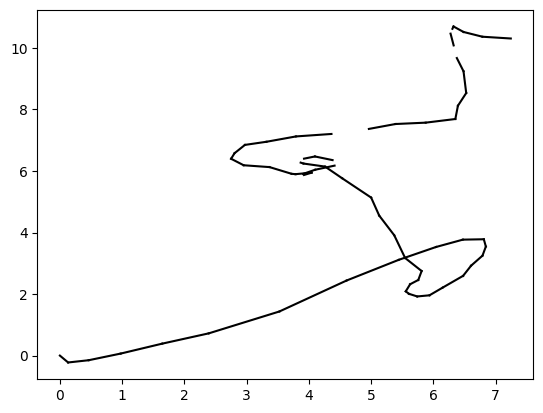

Epoch 0.42047531992687387 Iteration 230 loss: -1.5755726053815846


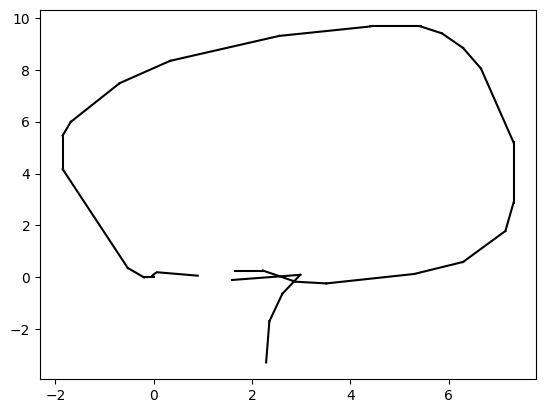

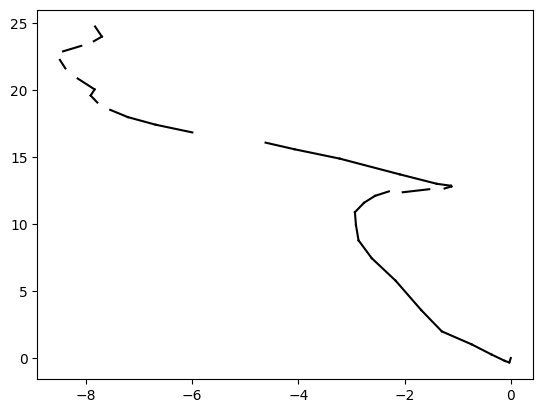

Epoch 0.43875685557586835 Iteration 240 loss: -1.6169818619544136


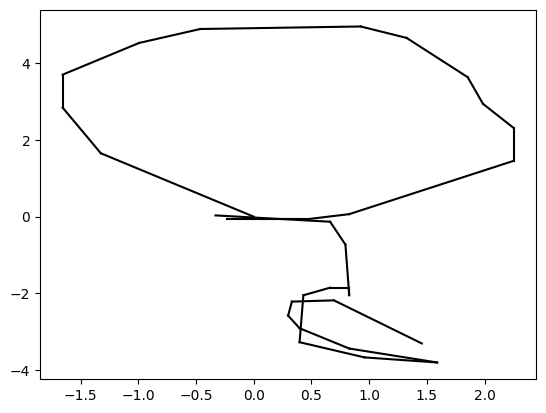

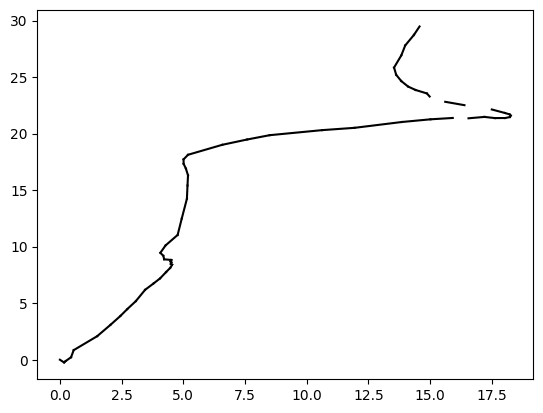

Epoch 0.4570383912248629 Iteration 250 loss: -1.65807831823878


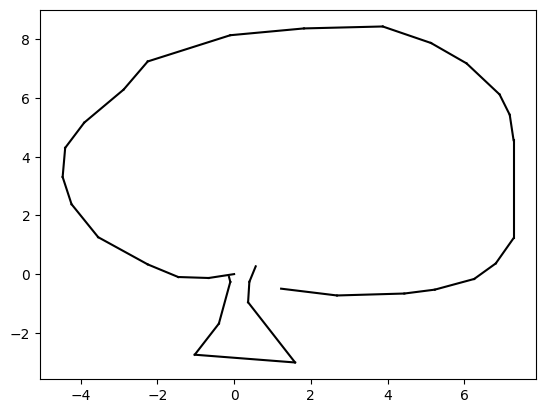

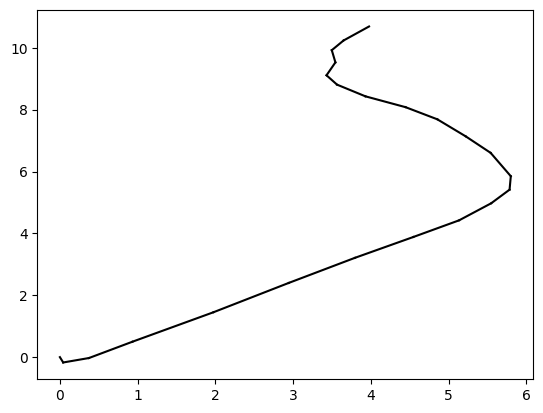

Epoch 0.4753199268738574 Iteration 260 loss: -1.6989525300497428


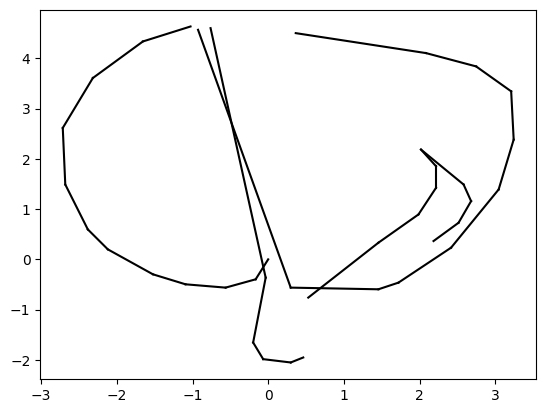

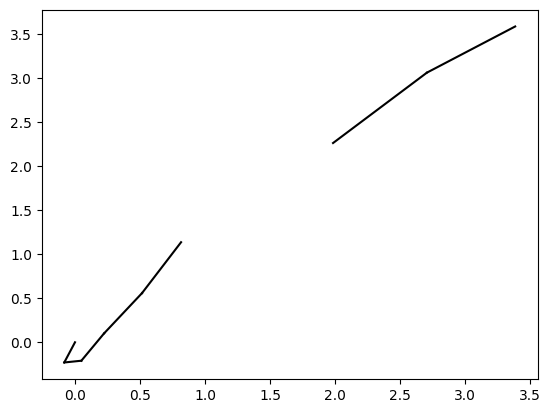

Epoch 0.4936014625228519 Iteration 270 loss: -1.7365400316257824


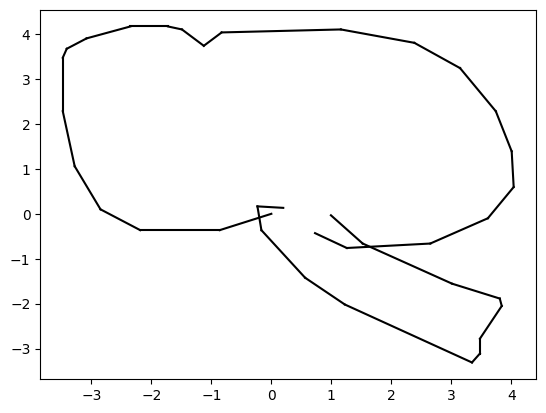

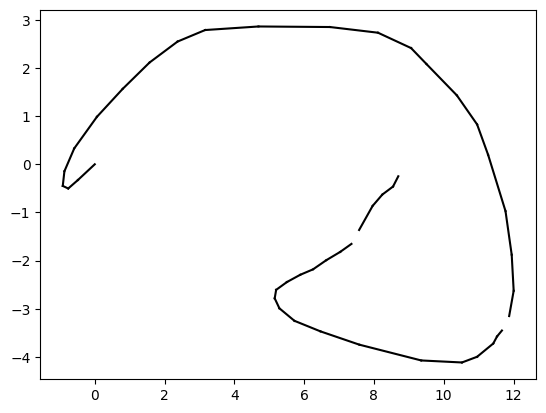

Epoch 0.5118829981718465 Iteration 280 loss: -1.7728628821577759


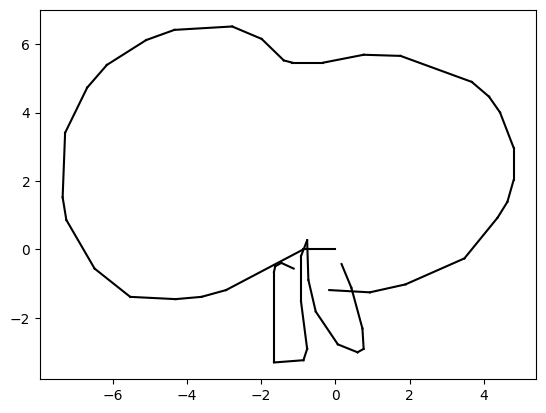

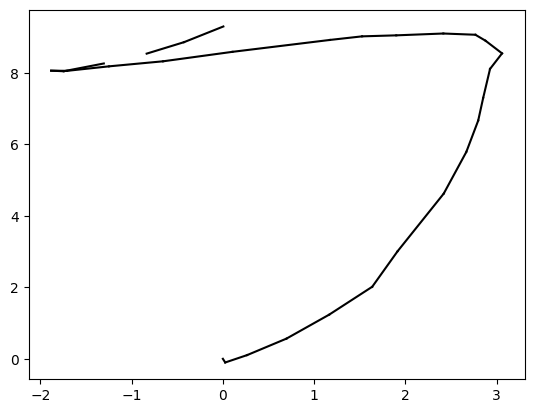

Epoch 0.5301645338208409 Iteration 290 loss: -1.8061663900479767


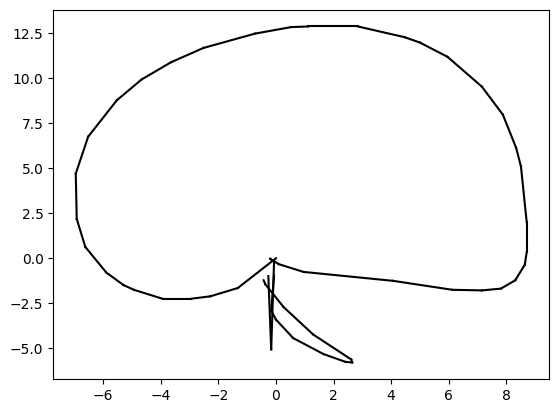

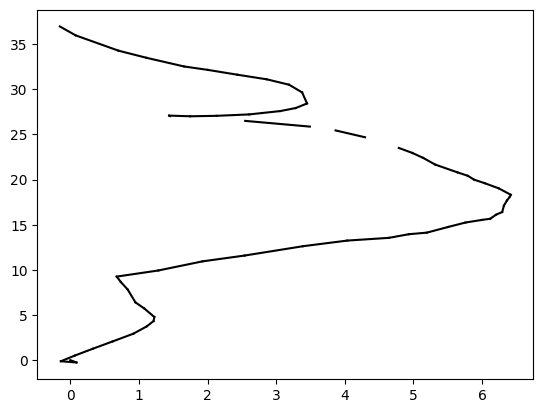

Epoch 0.5484460694698354 Iteration 300 loss: -1.837780041933185


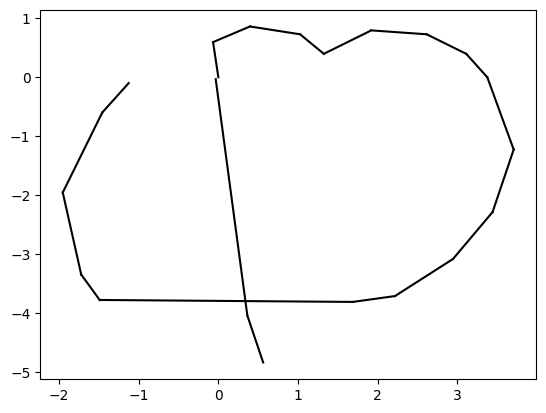

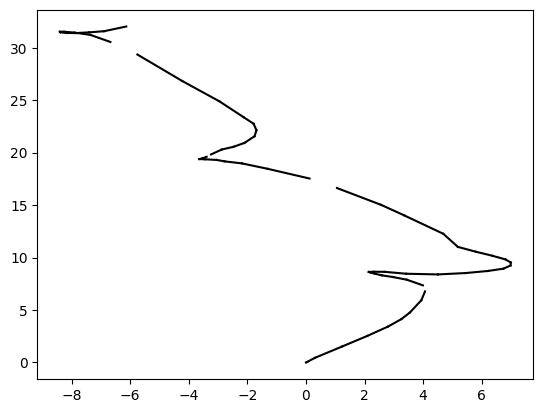

Epoch 0.56672760511883 Iteration 310 loss: -1.8694893953293639


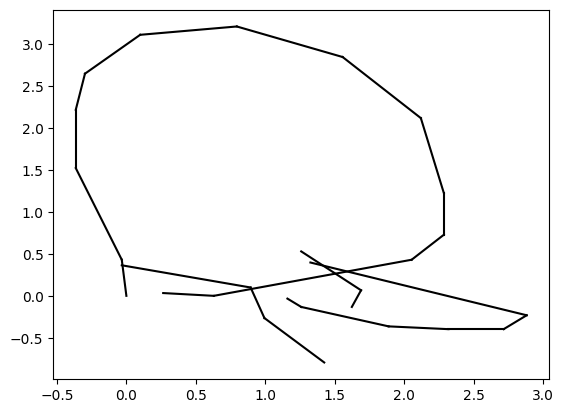

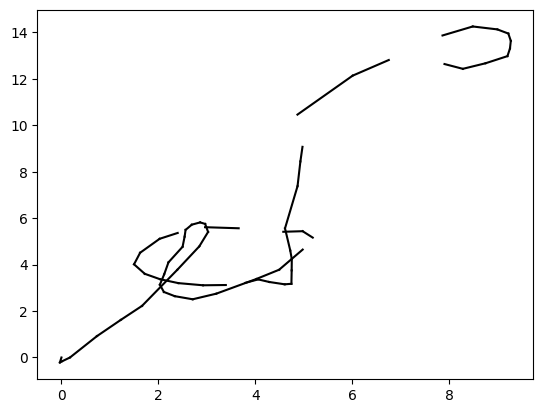

Epoch 0.5850091407678245 Iteration 320 loss: -1.899051782074038


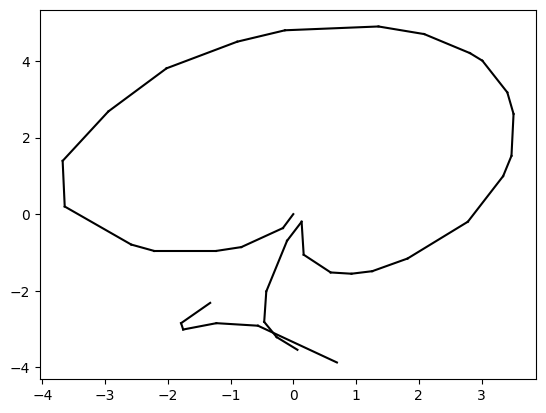

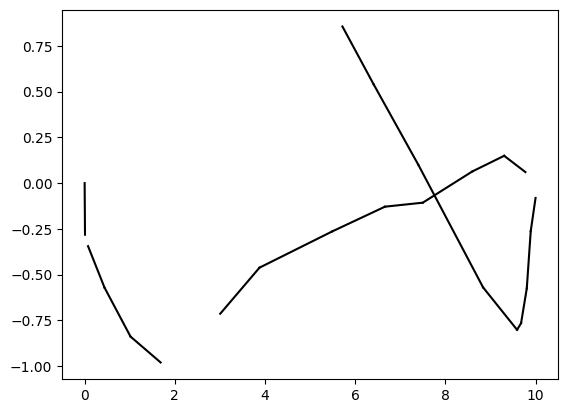

Epoch 0.603290676416819 Iteration 330 loss: -1.9278825516290816


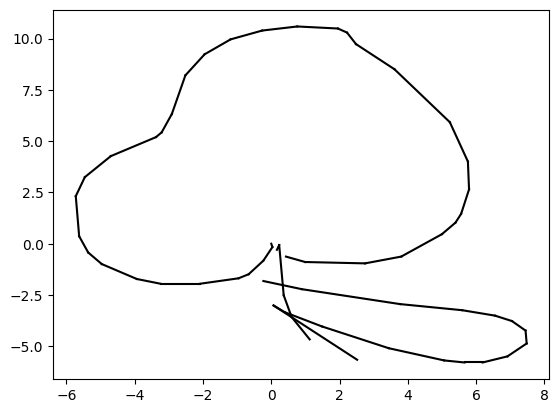

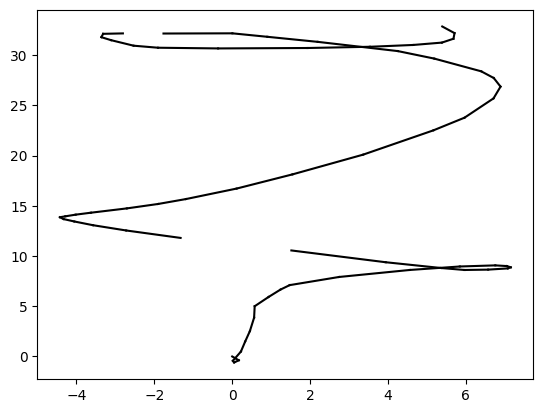

Epoch 0.6215722120658135 Iteration 340 loss: -1.9543530258472237


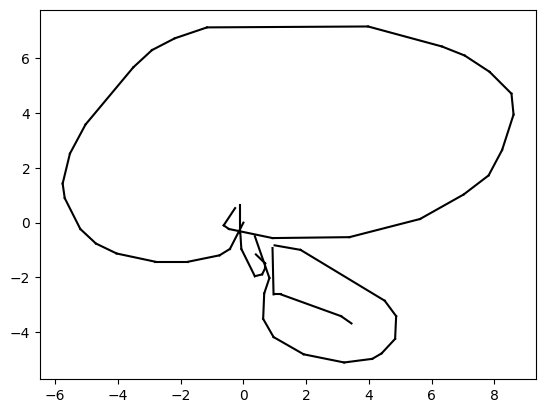

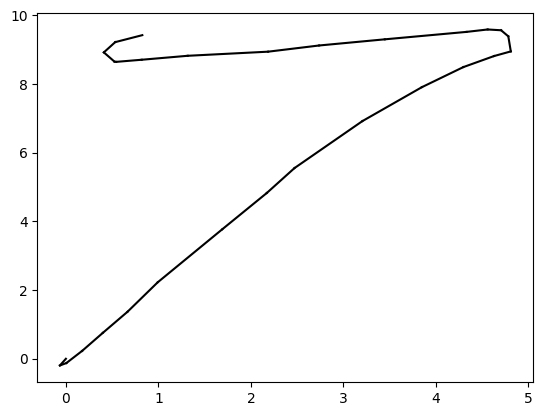

Epoch 0.6398537477148081 Iteration 350 loss: -1.9802211645096834


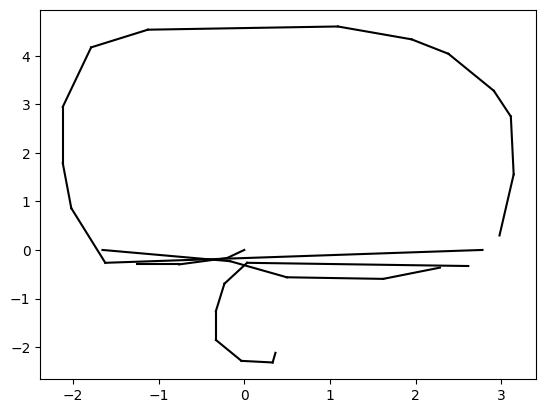

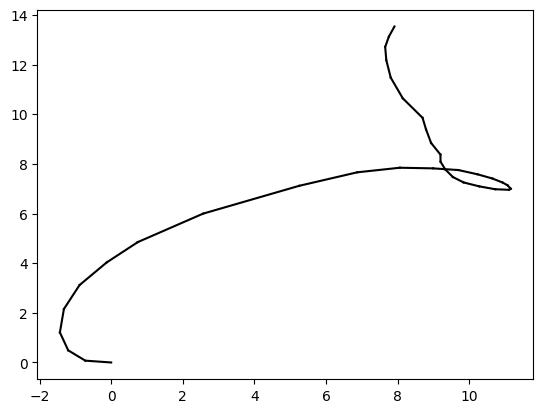

Epoch 0.6581352833638026 Iteration 360 loss: -2.006991724901798


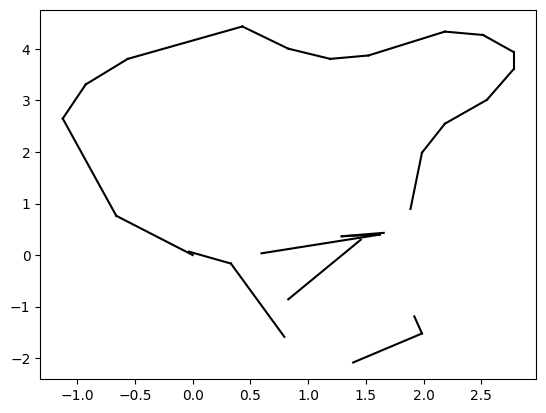

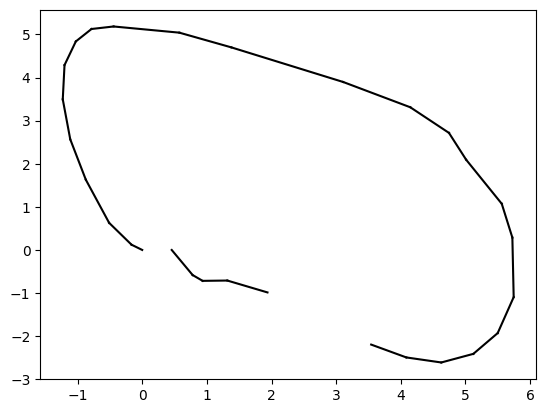

Epoch 0.676416819012797 Iteration 370 loss: -2.0320884950525175


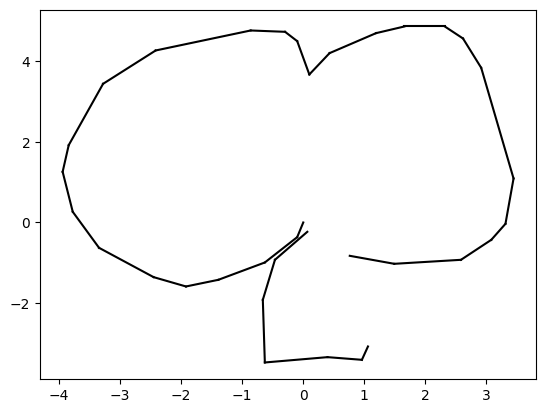

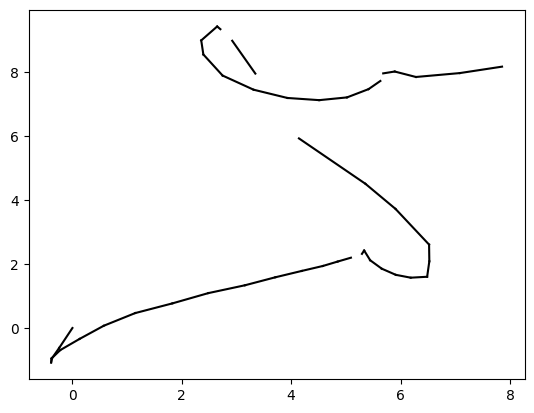

Epoch 0.6946983546617916 Iteration 380 loss: -2.0556714648999503


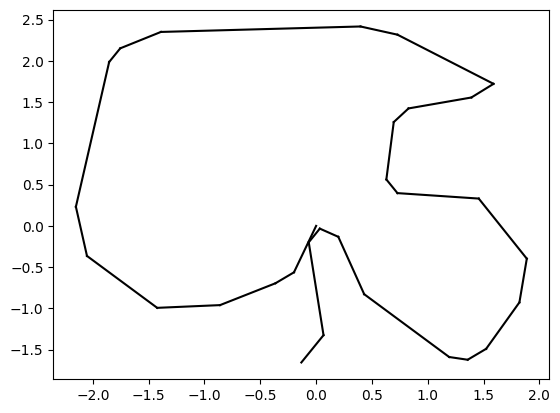

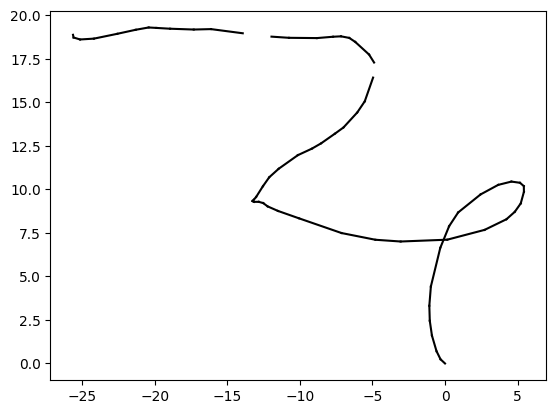

Epoch 0.7129798903107861 Iteration 390 loss: -2.0794933733583165


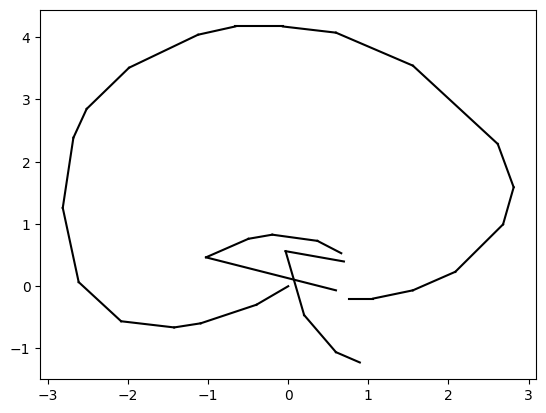

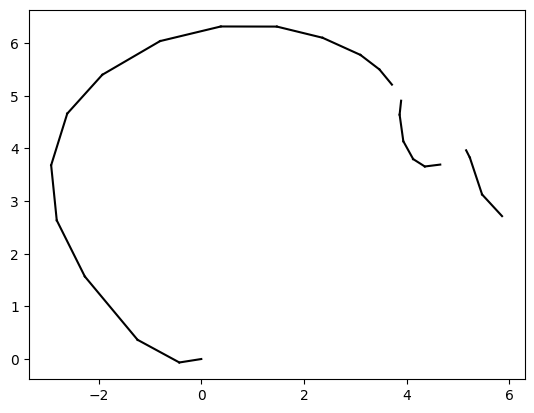

Epoch 0.7312614259597806 Iteration 400 loss: -2.102814719753875


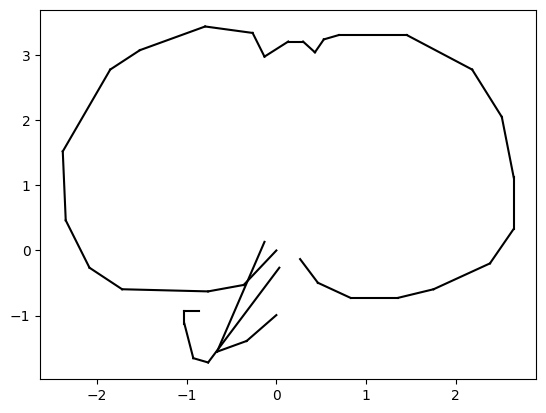

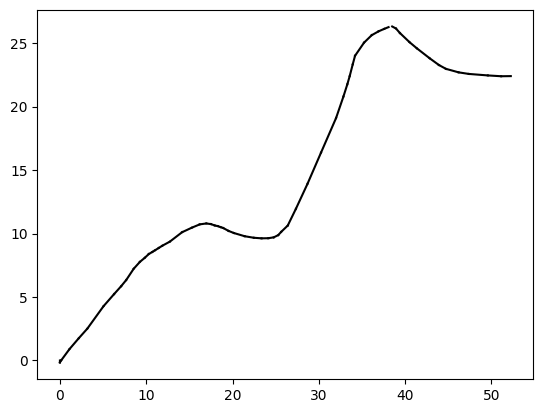

Epoch 0.7495429616087751 Iteration 410 loss: -2.124196024582745


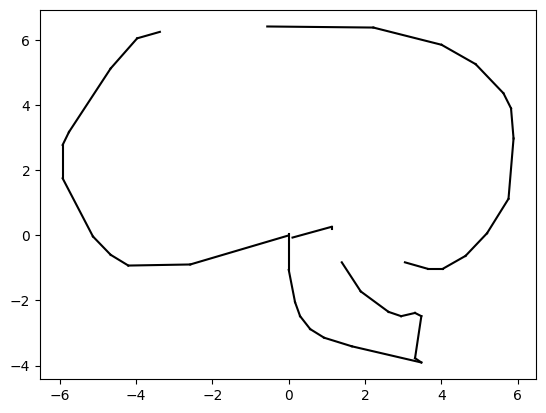

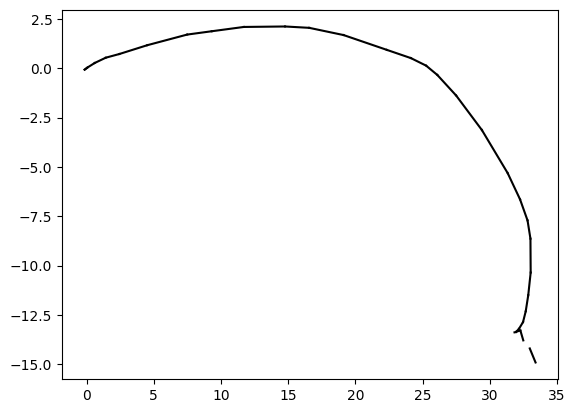

Epoch 0.7678244972577697 Iteration 420 loss: -2.1446313676357787


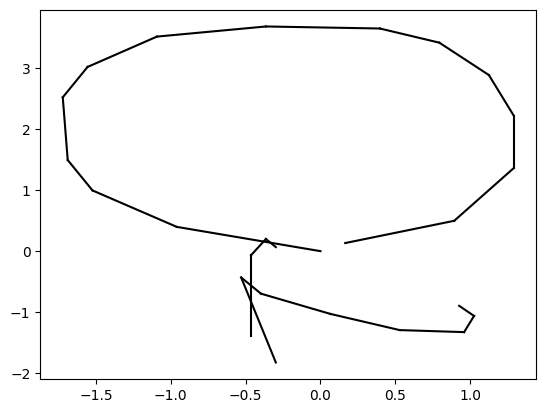

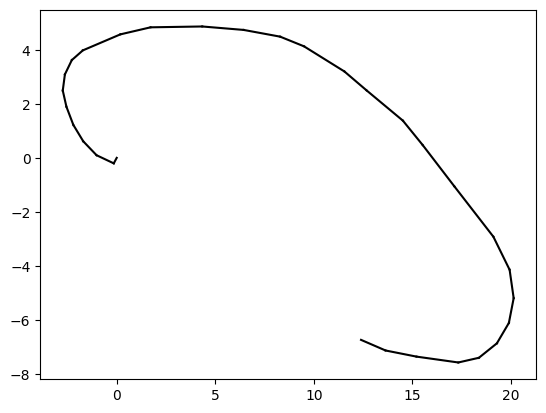

Epoch 0.7861060329067642 Iteration 430 loss: -2.165440575556859


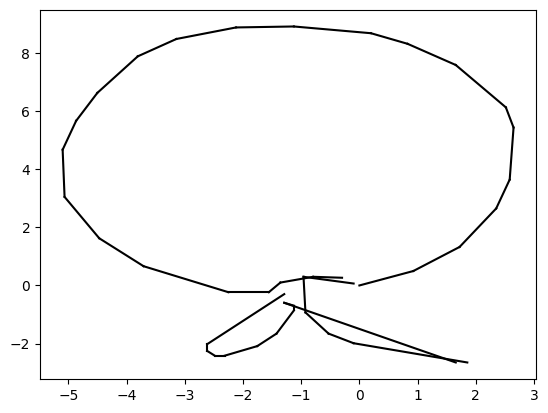

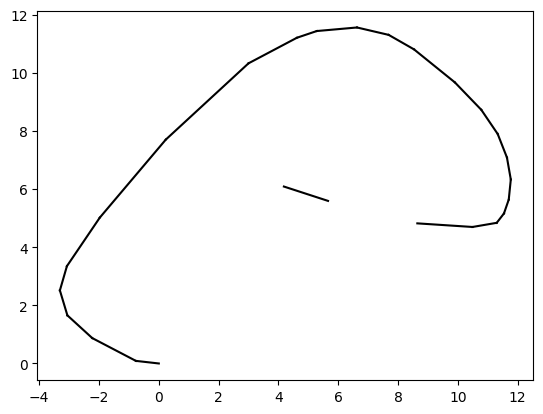

Epoch 0.8043875685557587 Iteration 440 loss: -2.185231852282904


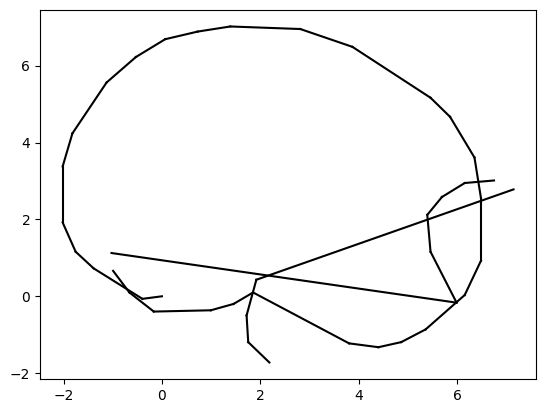

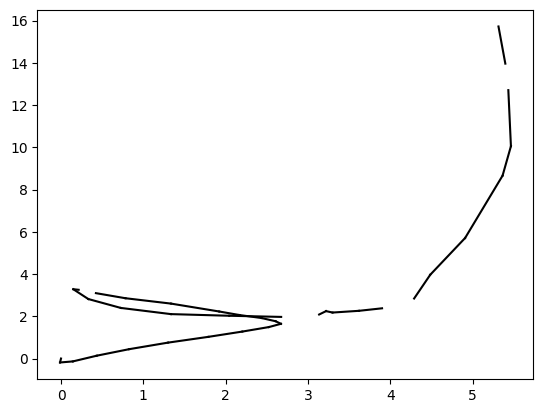

Epoch 0.8226691042047533 Iteration 450 loss: -2.2047619897425803


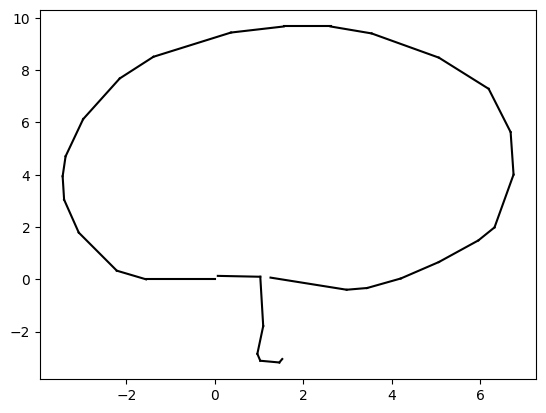

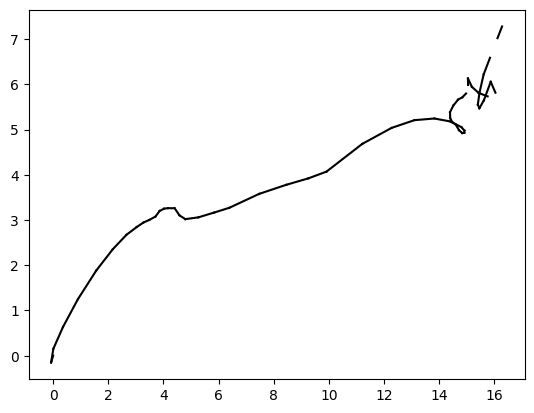

Epoch 0.8409506398537477 Iteration 460 loss: -2.224366683498957


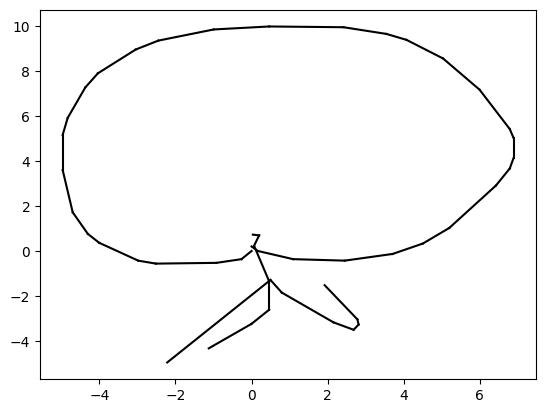

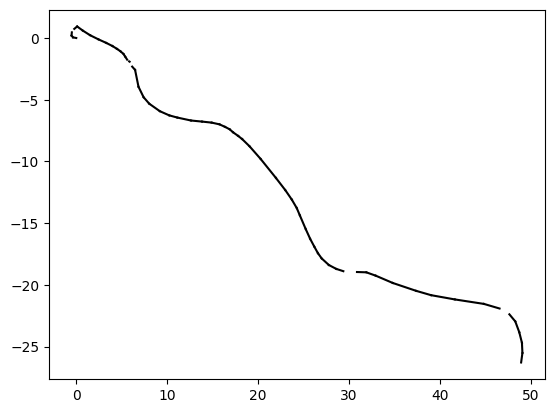

KeyboardInterrupt: 

In [35]:
from dezero.optimizers import Adam

model = SketchVAE(d_z, enc_hidden_size, dec_hidden_size, longest_seq_len)

model.to_gpu()
optimizer = Adam().setup(model)

test_batch = None
interval = 10
print("is cuda enabled", dezero.cuda.gpu_enable)

strokes.to_gpu()

# clean up gpu memory
import gc


for epoch in range(epochs):
    avg_loss = 0
    cnt = 0
    print("starting epoch", epoch)
    for i in range(strokes.max_iter - 1):
        model.encoder.lstm.reset_state()
        model.decoder.lstm.reset_state()
        x, t = strokes.__next__()
        test_batch = x
        loss = model(x, t)
        
        model.cleargrads()
        loss.backward()
        optimizer.update()
        avg_loss += loss.data
        if cnt % interval == 0:
            epoch_detail = epoch + cnt / strokes.max_iter
            print(f"Epoch {epoch_detail} Iteration {cnt} loss: {avg_loss / cnt}")
            # change xp array to numpy array
            plot_strokes_sequence(test_batch[0].get())
            plot_strokes_sequence(model.conditional_generation(test_batch))
            plt.close()
        cnt += 1


In [2]:
model.to_gpu()
model.conditional_generation(test_batch)

NameError: name 'model' is not defined

In [ ]:
model.cleargrads()

In [ ]:
print(x.shape)

In [ ]:
generated = model.conditional_generation(x)

In [ ]:
generated.shape

In [ ]:
x[0].shape

In [ ]:
len(generated)

In [ ]:
plot_strokes_sequence(generated.data)

In [ ]:
plot_strokes_sequence(x[0])